# Musical Composer Prediction - Group 8

Contributors: Bhupal Lambodhar, Aaron Ramirez, Elan Wilkinson

![alt text](composer_prediction_smaller.png "Predicting Classical Composers from Music")

Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using three deep learning techniques: Bidirectional Long Short-Term Memory (LSTM), Convolutional Neural Network (CNN), and Self-Attention Transformer. Classification will be performed for .mid files for four composers; Bach, Beethoven, Chopin, and Mozart.

Input data was fed into separate LSTM, CNN, and Selt-Attention Transformer models and further evaluation and hyperparameter tuning was performed in the pursuit of optimal correct classification of the composer giving a piece of music stored in a .mid file.

## Setup

### Mount drive

This step is for mounting of the drive to allow data access within colab, but is not necessary if running within a local environment.

In [1]:
# Mount drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install and Import Necessary Libraries

In [22]:
#!pip install pretty_midi
import pretty_midi
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import shapiro, anderson, kstest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Input, Layer, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LSTM, BatchNormalization, Bidirectional, Multiply, Permute
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import librosa.display
import seaborn as sns
from tqdm.notebook import tqdm as notebook_tqdm
from itertools import product
import warnings

warnings.filterwarnings('ignore')

## Data Preprocessing and Feature Engineering

### MIDI Feature Extraction and Standardization

#### Overview

The following is a comprehensive pipeline for extracting and standardizing various features from `MIDI` files. The extracted features include musical attributes such as `note sequences`, `tempo`, `duration`, `velocity statistics`, `pitch range`, and more. These features are then standardized to prepare the dataset for machine learning models.

#### Features Extracted

We focus on extracting various features from MIDI files to prepare the dataset for composer classification. The features are categorized into low-level, and high-level relevant features:

1. Low-level Features:

  - RMS (Root Mean Square) of velocities
  - Spectral Flux of velocities
  - Zero Crossing Rate of velocities

2. High-level Features:

  - Note Sequence
  - Duration
  - Tempo
  - Time Signature (numerator and denominator)
  - Key Signature
  - Average Velocity
  - Maximum Velocity
  - Minimum Velocity
  - Velocity Standard Deviation
  - Pitch Range
  - Number of Instruments
  - Note Density
  - Number of Notes
  - Average Pitch
  - Maximum Pitch
  - Minimum Pitch
  - Pitch Standard Deviation
  - Number of Articulations


Using Pretty_Midi, the file paths are converted into pretty_midi midi data. Notes and velocities from each instrument are appended to lists, with the exception of drums. The root mean square, spectral flux and zero crossing rate of the velocities as well as other computed measures are calculated and returned for each file. This is combined with composer data into a Pandas dataframe, and then saved into a csv for later reuse.

In [25]:
# Function to extract features from a MIDI file
midis = []

def extract_features(midi_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        midis.append(midi_data)

        note_seq = []
        velocities = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    note_seq.append(note.pitch)
                    velocities.append(note.velocity)

        # Calculate additional features
        if len(note_seq) > 0:
            pitch_range = max(note_seq) - min(note_seq)
        else:
            pitch_range = 0

        # Using the reference code to extract additional features
        # Extract low-level features
        rms = np.sqrt(np.mean(np.square(velocities))) if velocities else 0
        spectral_flux = np.mean(np.diff(velocities)) if len(velocities) > 1 else 0
        zero_crossing_rate = np.mean(np.diff(np.sign(velocities))) if len(velocities) > 1 else 0

        return {
            'note_sequence': note_seq,
            'duration': midi_data.get_end_time(),
            'tempo': midi_data.estimate_tempo(),
            'time_signature_numerator': midi_data.time_signature_changes[0].numerator if midi_data.time_signature_changes else 4,
            'time_signature_denominator': midi_data.time_signature_changes[0].denominator if midi_data.time_signature_changes else 4,
            'key_signature': midi_data.key_signature_changes[0].key_number if midi_data.key_signature_changes else None,
            'average_velocity': np.mean(velocities) if velocities else 0,
            'max_velocity': np.max(velocities) if velocities else 0,
            'min_velocity': np.min(velocities) if velocities else 0,
            'velocity_std': np.std(velocities) if velocities else 0,
            'pitch_range': pitch_range,
            'num_instruments': len([inst for inst in midi_data.instruments if not inst.is_drum]),
            'note_density': len(note_seq) / midi_data.get_end_time() if midi_data.get_end_time() > 0 else 0,
            'num_notes': len(note_seq),
            'average_pitch': np.mean(note_seq) if note_seq else 0,
            'max_pitch': np.max(note_seq) if note_seq else 0,
            'min_pitch': np.min(note_seq) if note_seq else 0,
            'pitch_std': np.std(note_seq) if note_seq else 0,
            'articulations': sum([len(inst.control_changes) for inst in midi_data.instruments]),
            # Additional features
            'rms': rms,
            'spectral_flux': spectral_flux,
            'zero_crossing_rate': zero_crossing_rate,
        }
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None

# Define the path to the extracted MIDI files
base_dir = '/content/drive/My Drive/AAI_511_NN/'
#base_dir = 'data\midiclassics'

# Define directories and parameters
extraction_dir = os.path.join(base_dir, './data')
#extraction_dir = base_dir

# Extract features for all MIDI files
data = []
for composer in os.listdir(extraction_dir):
    composer_folder = os.path.join(extraction_dir, composer)
    if os.path.isdir(composer_folder):
        for file in os.listdir(composer_folder):
            file_path = os.path.join(composer_folder, file)
            features = extract_features(file_path)
            if features:
                features['composer'] = composer
                data.append(features)

# Create a DataFrame with the extracted features
df = pd.DataFrame(data)
print(df.head())

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(base_dir, 'extracted_midi_features.csv'), index=False)


Error processing data\midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing data\midiclassics\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
                                       note_sequence   duration       tempo  \
0  [69, 69, 69, 69, 71, 67, 66, 64, 71, 73, 71, 6...  46.956456  184.000258   
1  [71, 64, 71, 72, 71, 69, 67, 69, 71, 71, 72, 7...  45.000000  109.714286   
2  [67, 69, 71, 69, 67, 66, 64, 62, 67, 69, 71, 7...  42.500000  140.800000   
3  [70, 72, 74, 72, 70, 69, 67, 65, 70, 72, 74, 7...  42.500000  140.800000   
4  [67, 69, 70, 69, 67, 67, 70, 69, 67, 74, 72, 7...  30.000000  147.692308   

   time_signature_numerator  time_signature_denominator  key_signature  \
0                         4                           4            9.0   
1                         4                           4           21.0   
2                         4                           4            7.0   
3

### Unused Data

Two files failed to successfully convert to midi data:
- Beethoven - Anhang 14-3.mid:
- Mozart - K281 Piano Sonata n03 3mov.mid:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   note_sequence               1635 non-null   object 
 1   duration                    1635 non-null   float64
 2   tempo                       1635 non-null   float64
 3   time_signature_numerator    1635 non-null   int64  
 4   time_signature_denominator  1635 non-null   int64  
 5   key_signature               1358 non-null   float64
 6   average_velocity            1635 non-null   float64
 7   max_velocity                1635 non-null   int64  
 8   min_velocity                1635 non-null   int64  
 9   velocity_std                1635 non-null   float64
 10  pitch_range                 1635 non-null   int64  
 11  num_instruments             1635 non-null   int64  
 12  note_density                1635 non-null   float64
 13  num_notes                   1635 

In [26]:
print('Number of midi files:', len(midis))

Number of midi files: 1635


#### Data Preparation

1. **Load Extracted Features**: Load the CSV file containing the extracted features.
2. **Format Note Sequences**: Ensure the note sequences are correctly formatted.
3. **Standardize Features**: Standardize numerical features using `StandardScaler` from `sklearn`.



In [18]:
# Load the extracted features dataset
df = pd.read_csv(os.path.join(base_dir,'extracted_midi_features.csv'))

# Ensure the note sequences are properly formatted
df['note_sequence'] = df['note_sequence'].apply(eval)

# Standardize the durations and tempos
scaler = StandardScaler()
df[['duration', 'tempo']] = scaler.fit_transform(df[['duration', 'tempo']])

# Standardize additional features
features_to_standardize = [
    'average_velocity', 'max_velocity', 'min_velocity', 'velocity_std',
    'pitch_range', 'num_instruments', 'note_density', 'num_notes',
    'average_pitch', 'max_pitch', 'min_pitch', 'pitch_std', 'articulations',
    'rms', 'spectral_flux', 'zero_crossing_rate'
]
df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

# Handle missing values in key_signature
df['key_signature'].fillna(df['key_signature'].mean(), inplace=True)

# Visualize the first few rows of the dataframe
print(df.head())

# Optionally, save the standardized DataFrame to a new CSV file
df.to_csv(os.path.join(base_dir, 'standardized_midi_features.csv'), index=False)


                                       note_sequence  duration     tempo  \
0  [53, 57, 60, 65, 69, 60, 65, 69, 53, 57, 60, 6... -0.706379  1.136376   
1  [70, 74, 77, 70, 75, 79, 82, 81, 79, 77, 75, 7...  1.620975 -0.254907   
2  [79, 63, 62, 63, 65, 67, 79, 77, 79, 77, 75, 7...  1.343909  1.287323   
3  [77, 76, 74, 73, 74, 73, 74, 76, 74, 73, 74, 7...  1.827895  0.259955   
4  [64, 67, 71, 60, 60, 62, 64, 60, 62, 60, 59, 5...  0.944828 -0.671717   

   time_signature_numerator  time_signature_denominator  key_signature  \
0                         4                           4       3.825269   
1                         4                           4       3.825269   
2                         4                           4       3.825269   
3                         2                           4       3.825269   
4                         4                           4       3.825269   

   average_velocity  max_velocity  min_velocity  velocity_std  ...  num_notes  \
0         -1.9573

### Examining Midi File Data

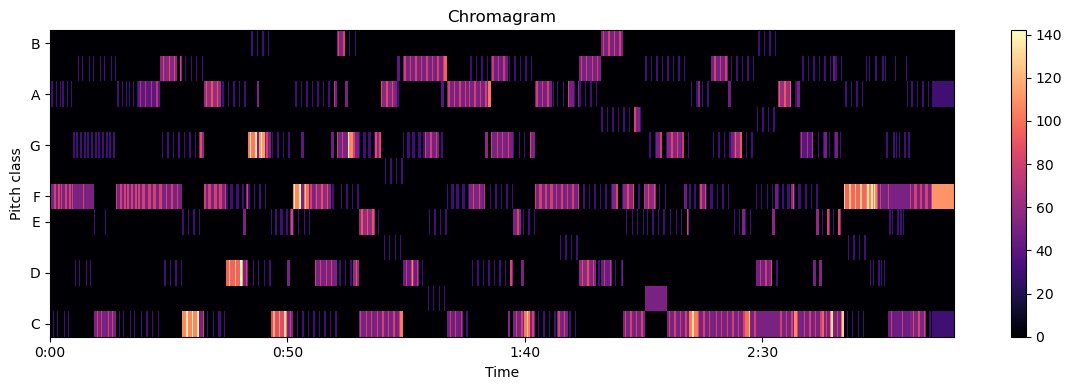

In [23]:
# Provide functionality to visualize chromogram(visualized pitch content) of a MIDI file
# and plot the chromagram of a MIDI file as an example 

def get_chroma(midi):
    chroma = midi.get_chroma()
    return chroma

def plot_chroma(chroma):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.show()


# Test using the first midi from the bach_midis
plot_chroma(get_chroma(midis[0]))

### Data Visualization of Extracted MIDI Features

#### Overview

This section of the notebook provides visualizations for various extracted features from MIDI files. The visualizations help in understanding the distribution and characteristics of the dataset, which is essential for further analysis and model training.

#### Features Visualized

The following features are visualized:

1. Low-level Features:

  - RMS (Root Mean Square) of velocities
  - Spectral Flux of velocities
  - Zero Crossing Rate of velocities

2. High-level Features:

  - Note Sequence
  - Duration
  - Tempo
  - Time Signature (numerator and denominator)
  - Key Signature
  - Average Velocity
  - Maximum Velocity
  - Minimum Velocity
  - Velocity Standard Deviation
  - Pitch Range
  - Number of Instruments
  - Note Density
  - Number of Notes
  - Average Pitch
  - Maximum Pitch
  - Minimum Pitch
  - Pitch Standard Deviation
  - Number of Articulations


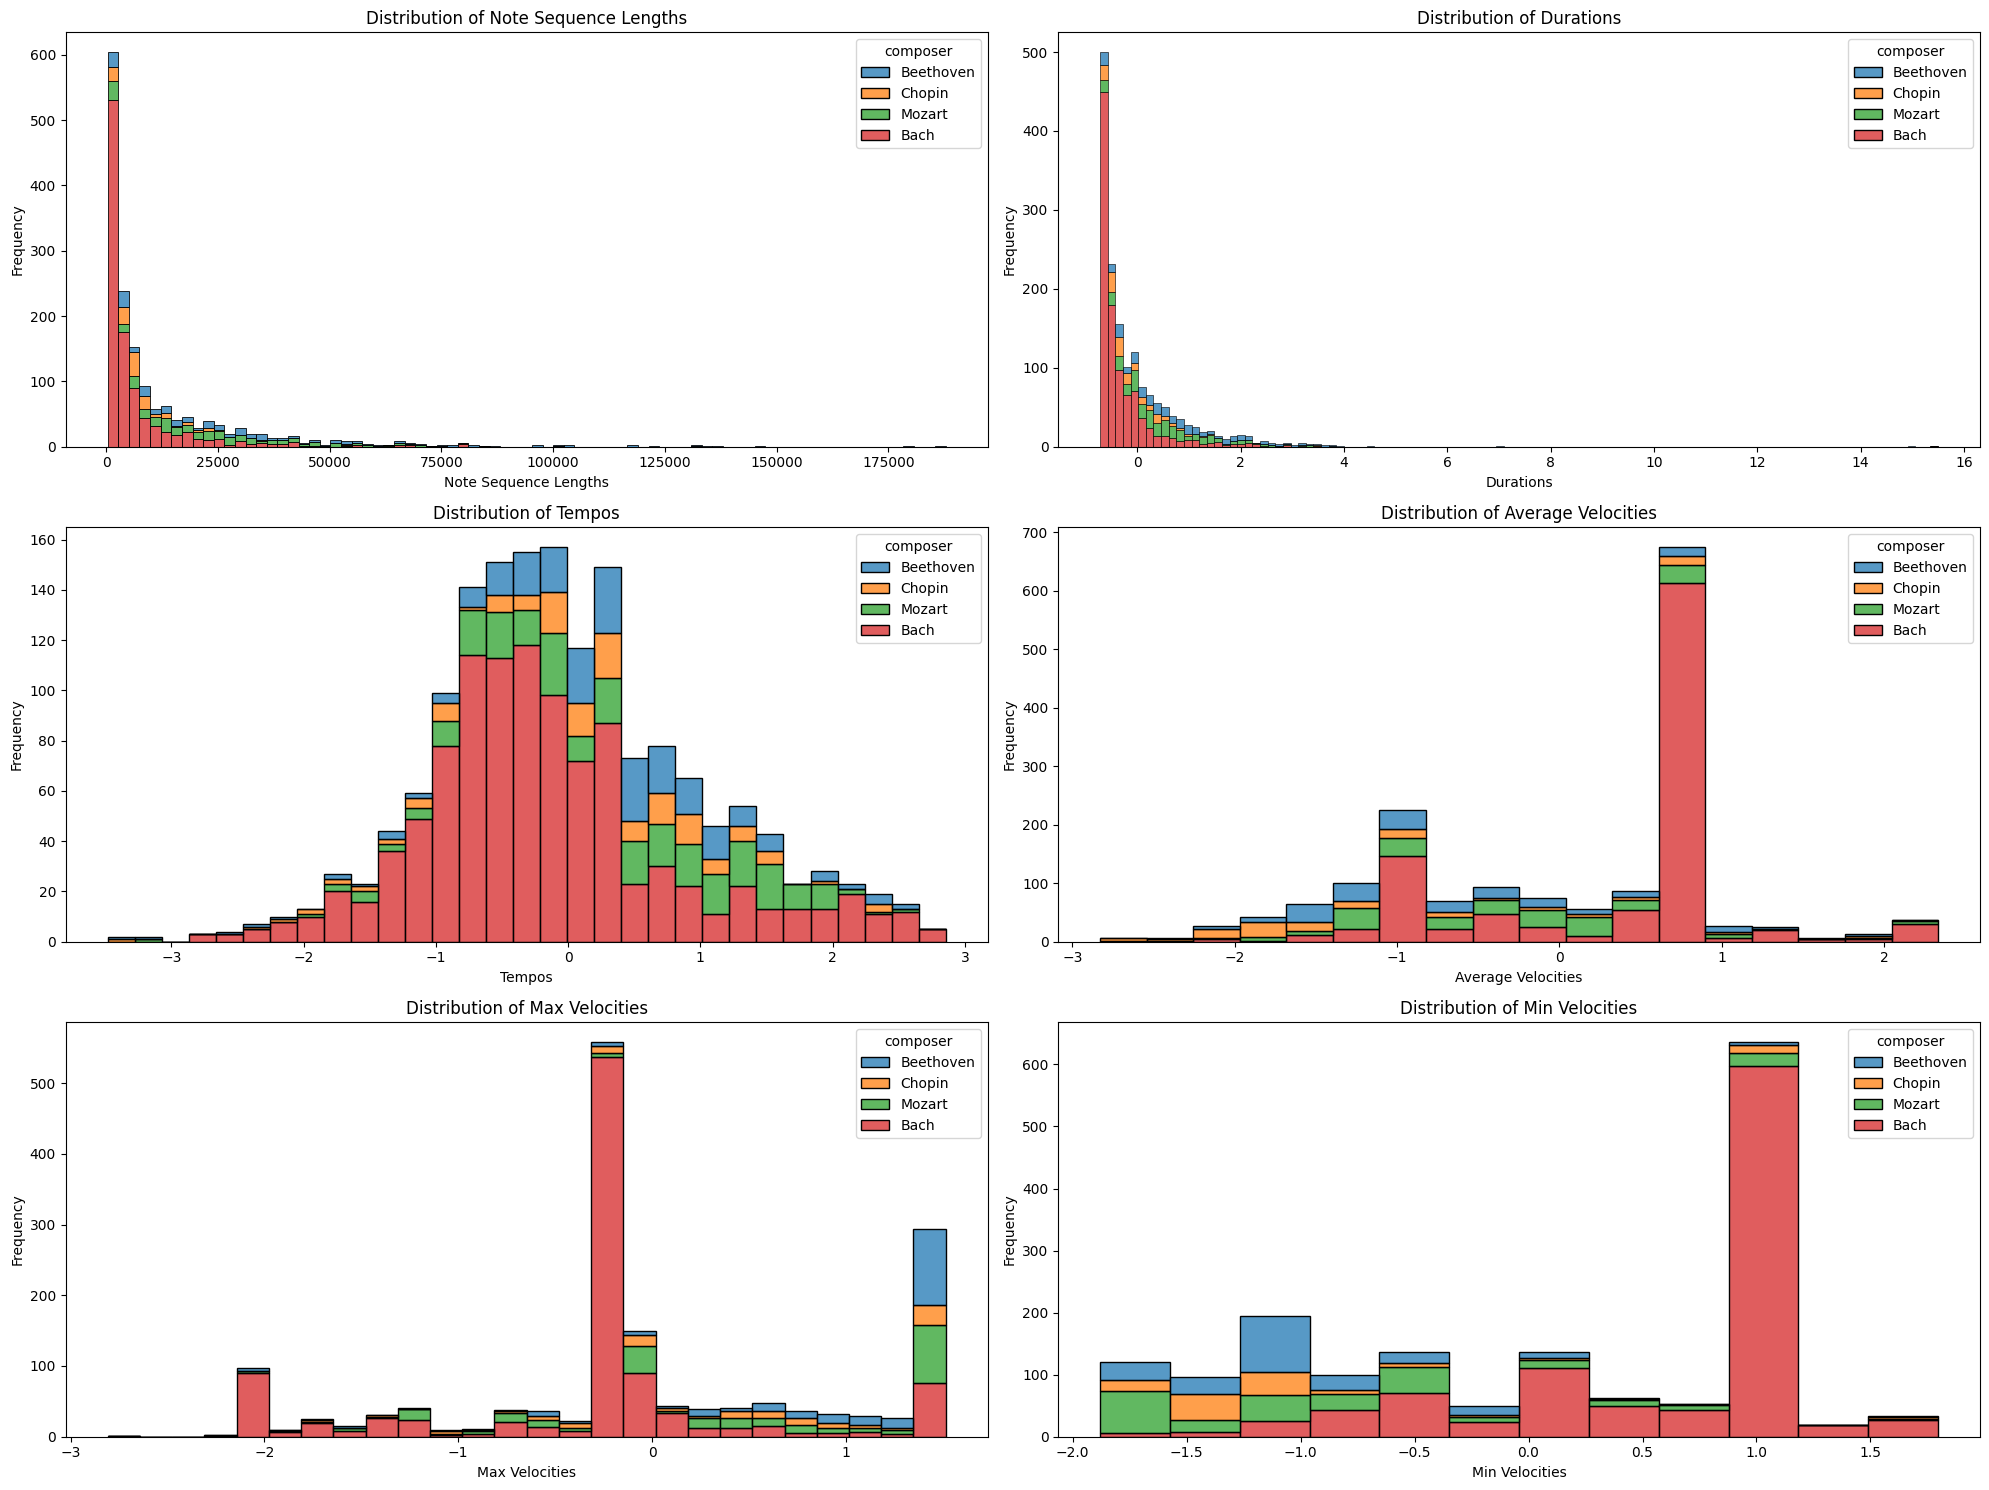

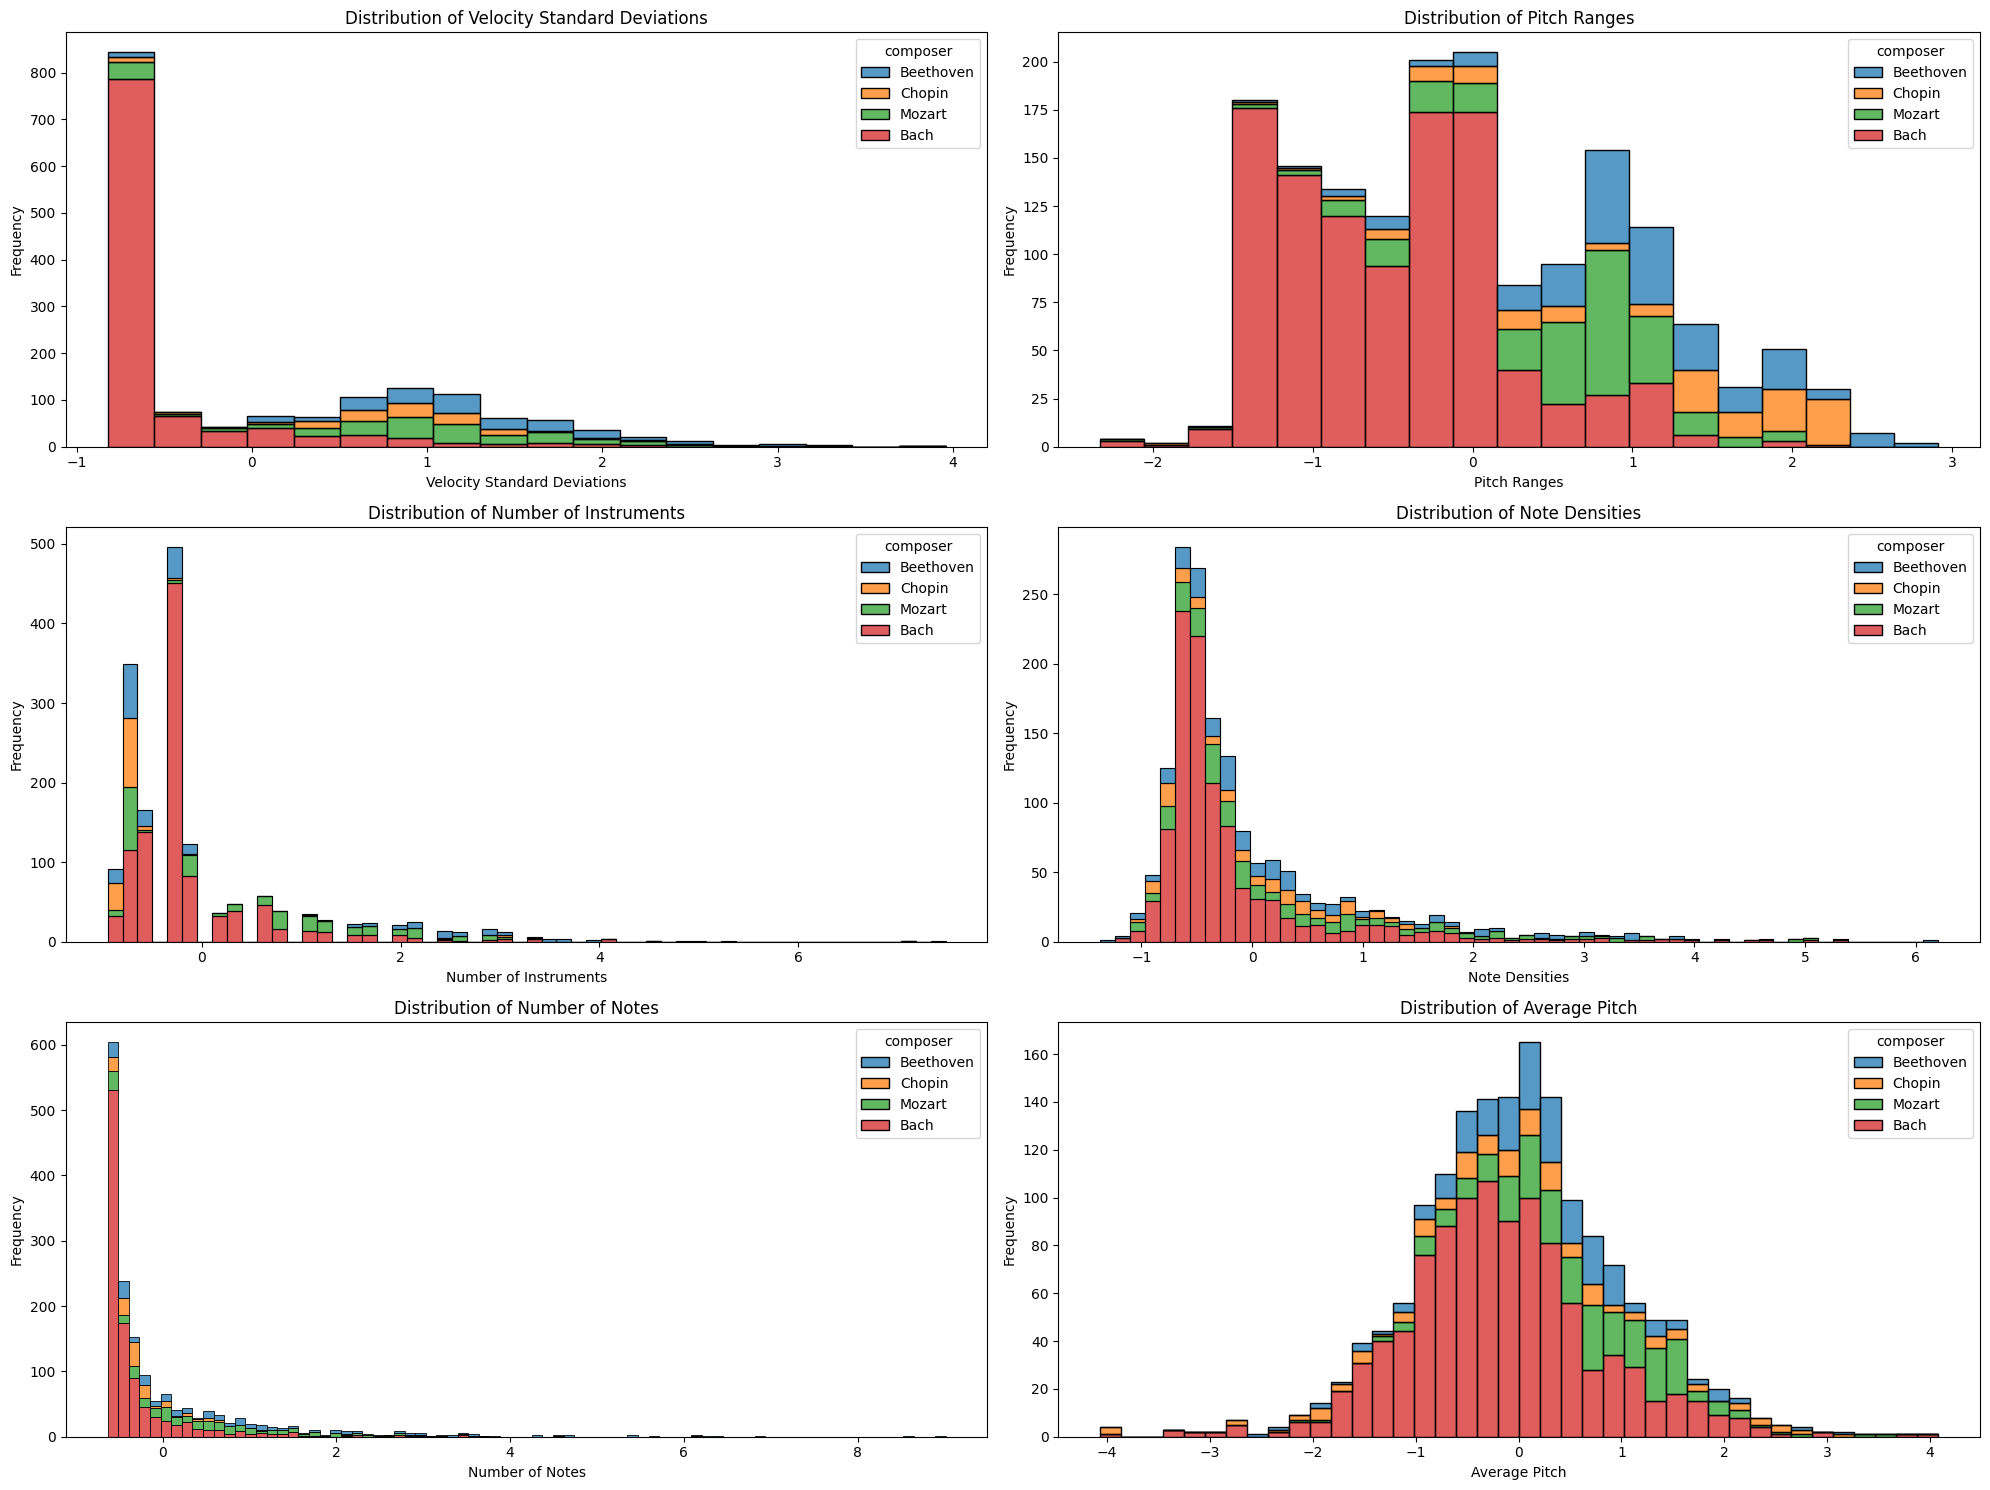

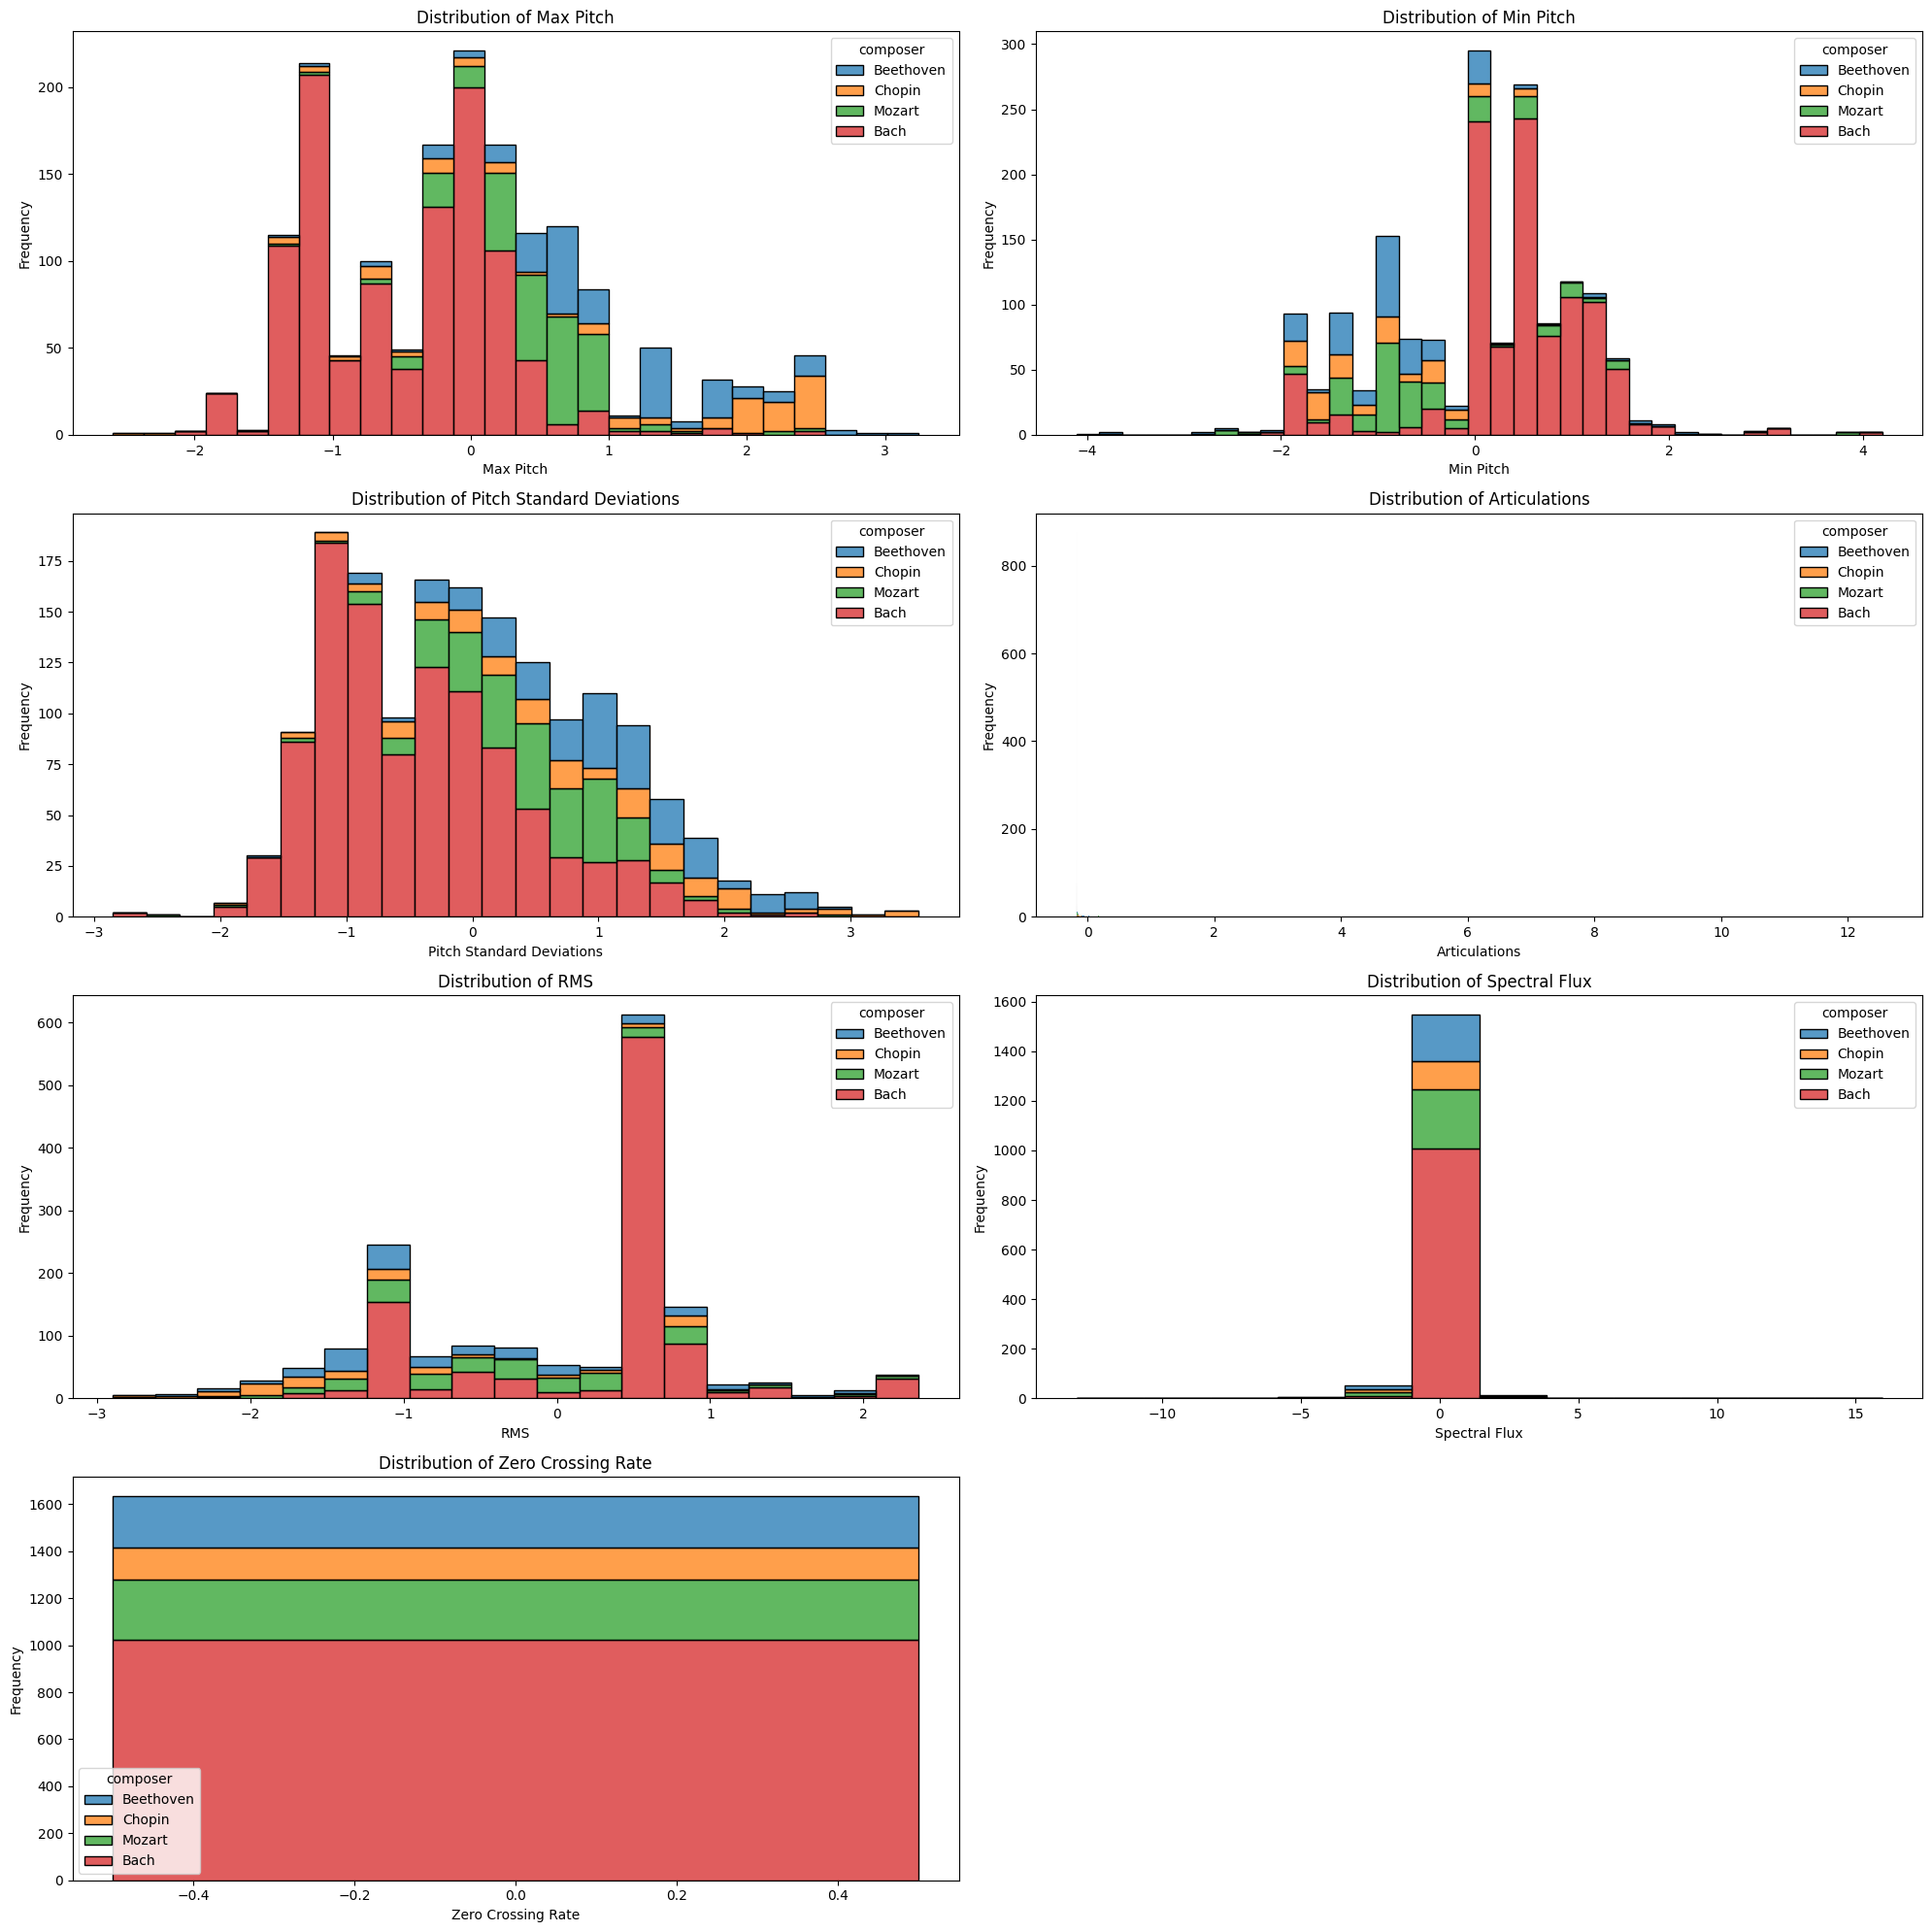

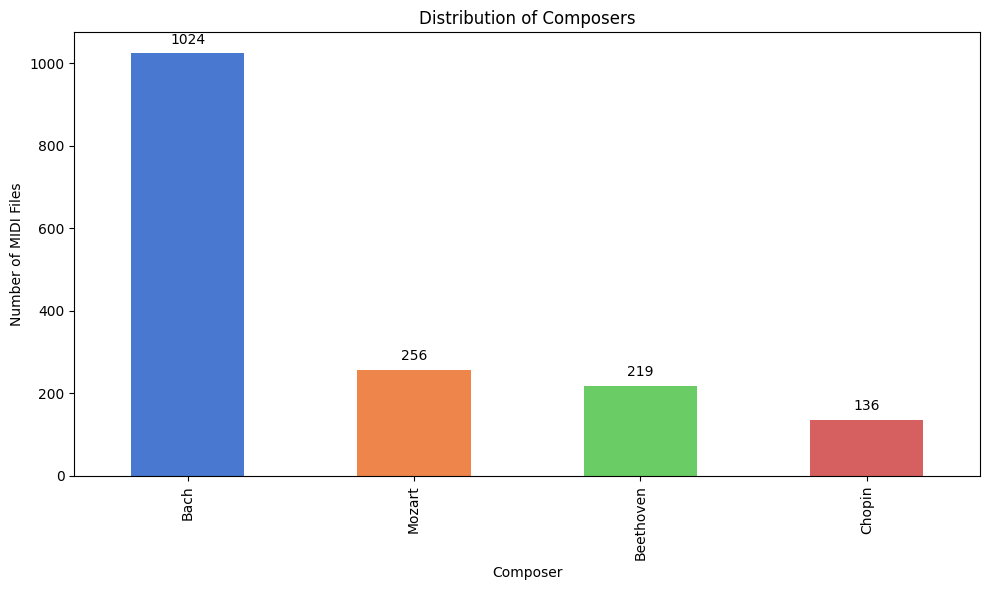

In [6]:
# Load the extracted features dataset
df = pd.read_csv(os.path.join(base_dir,'standardized_midi_features.csv'))

# Define the features and titles for the plots
features = [
    'note_sequence', 'duration', 'tempo', 'average_velocity', 'max_velocity',
    'min_velocity', 'velocity_std', 'pitch_range', 'num_instruments', 'note_density',
    'num_notes', 'average_pitch', 'max_pitch', 'min_pitch', 'pitch_std', 'articulations',
    'rms', 'spectral_flux', 'zero_crossing_rate'
]
titles = [
    'Note Sequence Lengths', 'Durations', 'Tempos', 'Average Velocities', 'Max Velocities',
    'Min Velocities', 'Velocity Standard Deviations', 'Pitch Ranges', 'Number of Instruments',
    'Note Densities', 'Number of Notes', 'Average Pitch', 'Max Pitch', 'Min Pitch',
    'Pitch Standard Deviations', 'Articulations', 'RMS', 'Spectral Flux', 'Zero Crossing Rate'
]

# Ensure the note sequences are properly formatted for lengths
df['note_sequence_length'] = df['note_sequence'].apply(len)

# Create a mapping for feature titles
feature_to_title = dict(zip(features, titles))

# Function to create subplots
def create_subplots(pdf, feature_subset):
    rows = (len(feature_subset) + 1) // 2
    fig, axs = plt.subplots(rows, 2, figsize=(20, 5 * rows))
    axs = axs.ravel()  # Flatten the 2D array of axes into a 1D array for easier indexing

    for i, feature in enumerate(feature_subset):
        if feature == 'note_sequence':
            data = df['note_sequence_length']
            title = feature_to_title[feature]
            sns.histplot(data=df, x=data, hue='composer', multiple='stack', ax=axs[i])
        else:
            data = df[feature]
            title = feature_to_title[feature]
            sns.histplot(data=df, x=feature, hue='composer', multiple='stack', ax=axs[i])
        axs[i].set_xlabel(title)
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Distribution of {title}')

    # Remove any unused subplots
    for j in range(len(feature_subset), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    pdf.savefig(fig)
    plt.show()  # Display the figure
    plt.close(fig)

# Save plots to a PDF
with PdfPages(os.path.join(base_dir,'midi_feature_distributions.pdf')) as pdf:
    create_subplots(pdf, features[:6])
    create_subplots(pdf, features[6:12])
    create_subplots(pdf, features[12:])

# Visualize the distribution of composers
composer_counts = df['composer'].value_counts()

plt.figure(figsize=(10, 6))
ax = composer_counts.plot(kind='bar', color=sns.color_palette("muted"))
plt.xlabel('Composer')
plt.ylabel('Number of MIDI Files')
plt.title('Distribution of Composers')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig(os.path.join(base_dir,'music_composer_distribution.pdf'))
plt.show()


The graph illustrates the number of MIDI file samples attributed to each composer within the dataset. Bach is prominently represented, with approximately 1000 samples, significantly outnumbering the other composers. Beethoven and Mozart each have around 250 samples, while Chopin has about 125 samples. This notable imbalance suggests that the dataset is heavily skewed towards Bach, which could lead to a bias in any trained models favoring Bach's musical patterns. The imbalance will later be addressed through Synthetic Minority Oversampling Technique (SMOTE).


### Visualizing Musical Notes and Hexadecimal Representation of MIDI Files

This script provides a comprehensive visualization of musical notes and the hexadecimal content of MIDI files for different composers. It aims to facilitate a deeper understanding of the structure and content of MIDI files by presenting both the musical and data representations side by side.

#### MIDI Files Directory Structure

The script scans through the directory structure where MIDI files are organized into subdirectories by composer.
```
data/
  ├── Bach/
  │   ├── file1.mid
  │   ├── file2.mid
  │   └── ...
  ├── Beethoven/
  │   ├── file1.mid
  │   ├── file2.mid
  │   └── ...
  ├── Chopin/
  │   ├── file1.mid
  │   ├── file2.mid
  │   └── ...
  └── Mozart/
      ├── file1.mid
      ├── file2.mid
      └── ...
```

#### Overview

1. **Extracting Notes**:
   - The script uses `pretty_midi` to extract the notes from each MIDI file. The notes are represented by their start time, end time, and pitch.

2. **Plotting Musical Notes**:
   - Musical notes are plotted using `matplotlib`. The x-axis represents the time in seconds, and the y-axis represents the pitch. Each note is represented by a vertical line (|) at its start time.

3. **Displaying Hexadecimal Content**:
   - The script reads the binary content of the MIDI file and converts it to a hexadecimal representation. This hexadecimal content is then formatted and displayed alongside the musical notes.

4. **Combining Plots**:
   - For each composer, the script processes up to three MIDI files and generates a combined plot for each file, displaying the musical notes on the left and the hexadecimal content on the right.


#### Plot Description

- **Musical Notes**:
  - The left-hand side of the plot displays the musical notes of each MIDI file. The x-axis represents the time in seconds, and the y-axis represents the pitch. Each note is depicted by a vertical line at its start time, providing a visual representation of the musical structure.

- **Hexadecimal Content**:
  - The right-hand side of the plot shows the hexadecimal representation of the MIDI file content. This display helps to understand the raw binary data that constitutes the MIDI file.

We can visualize the musical and data structure of MIDI files, providing valuable insights into their composition and encoding.

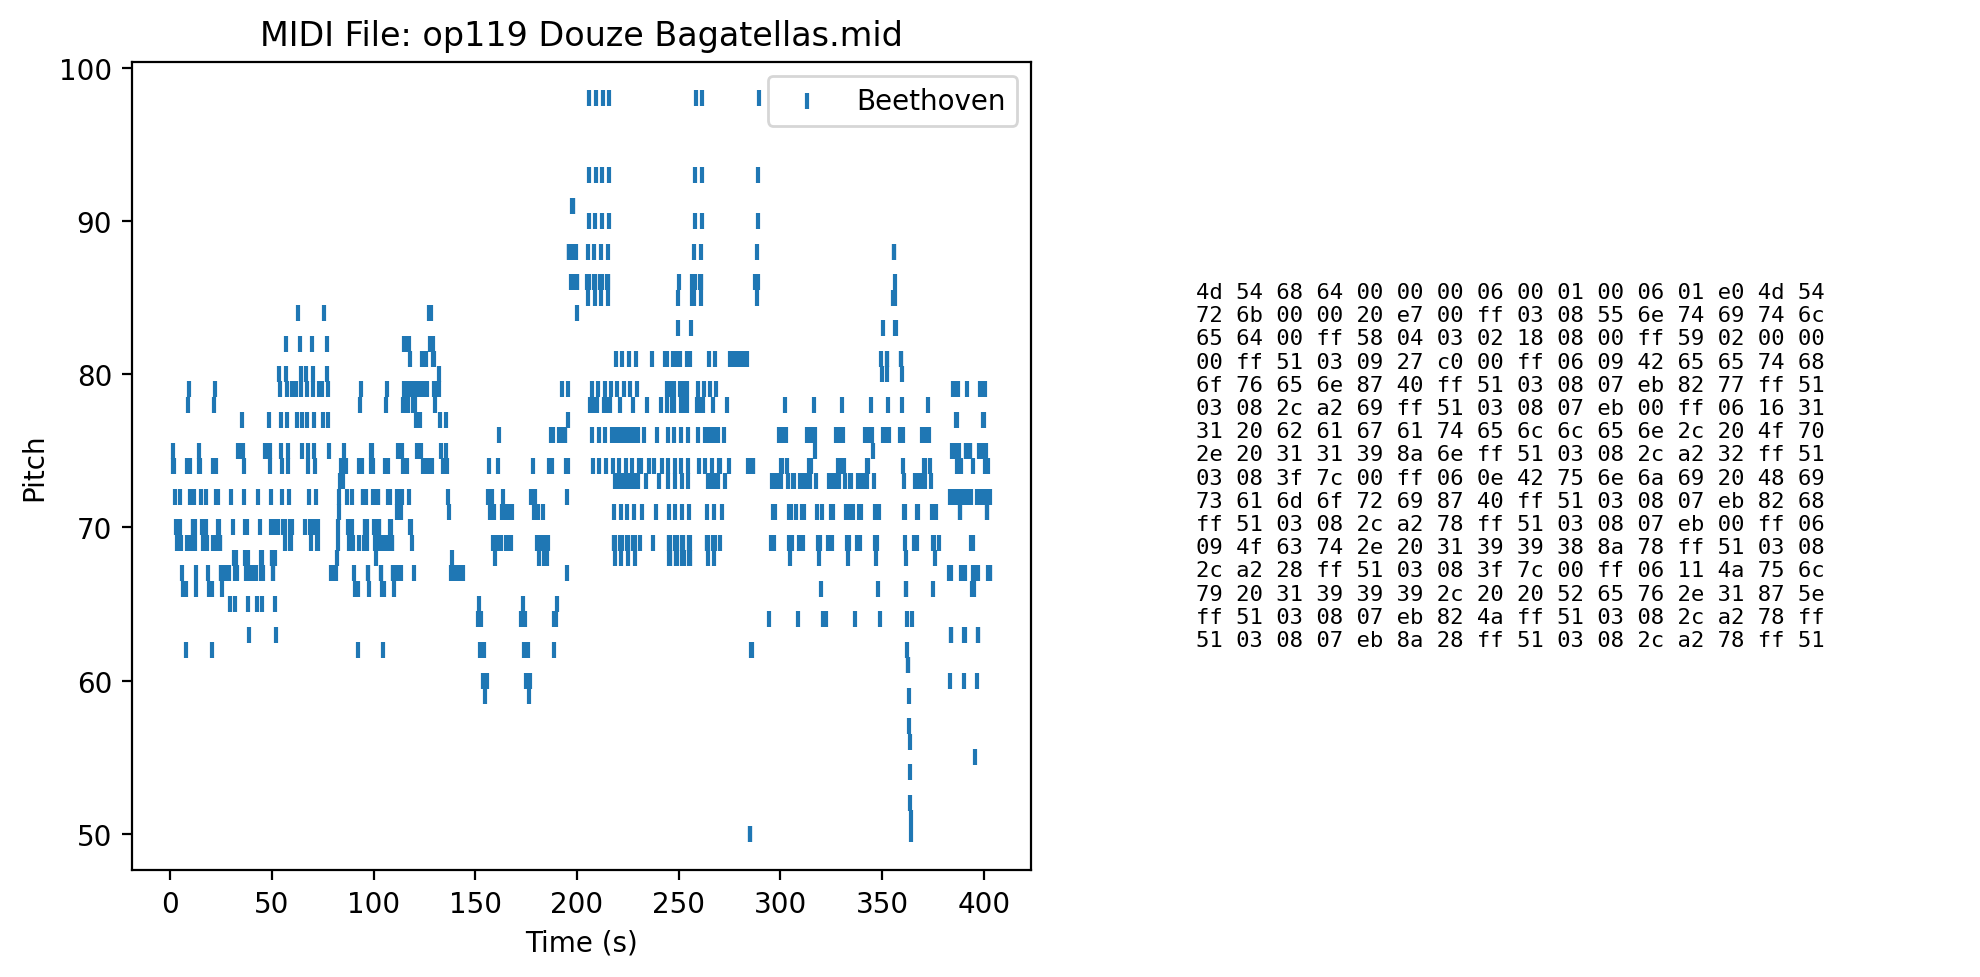

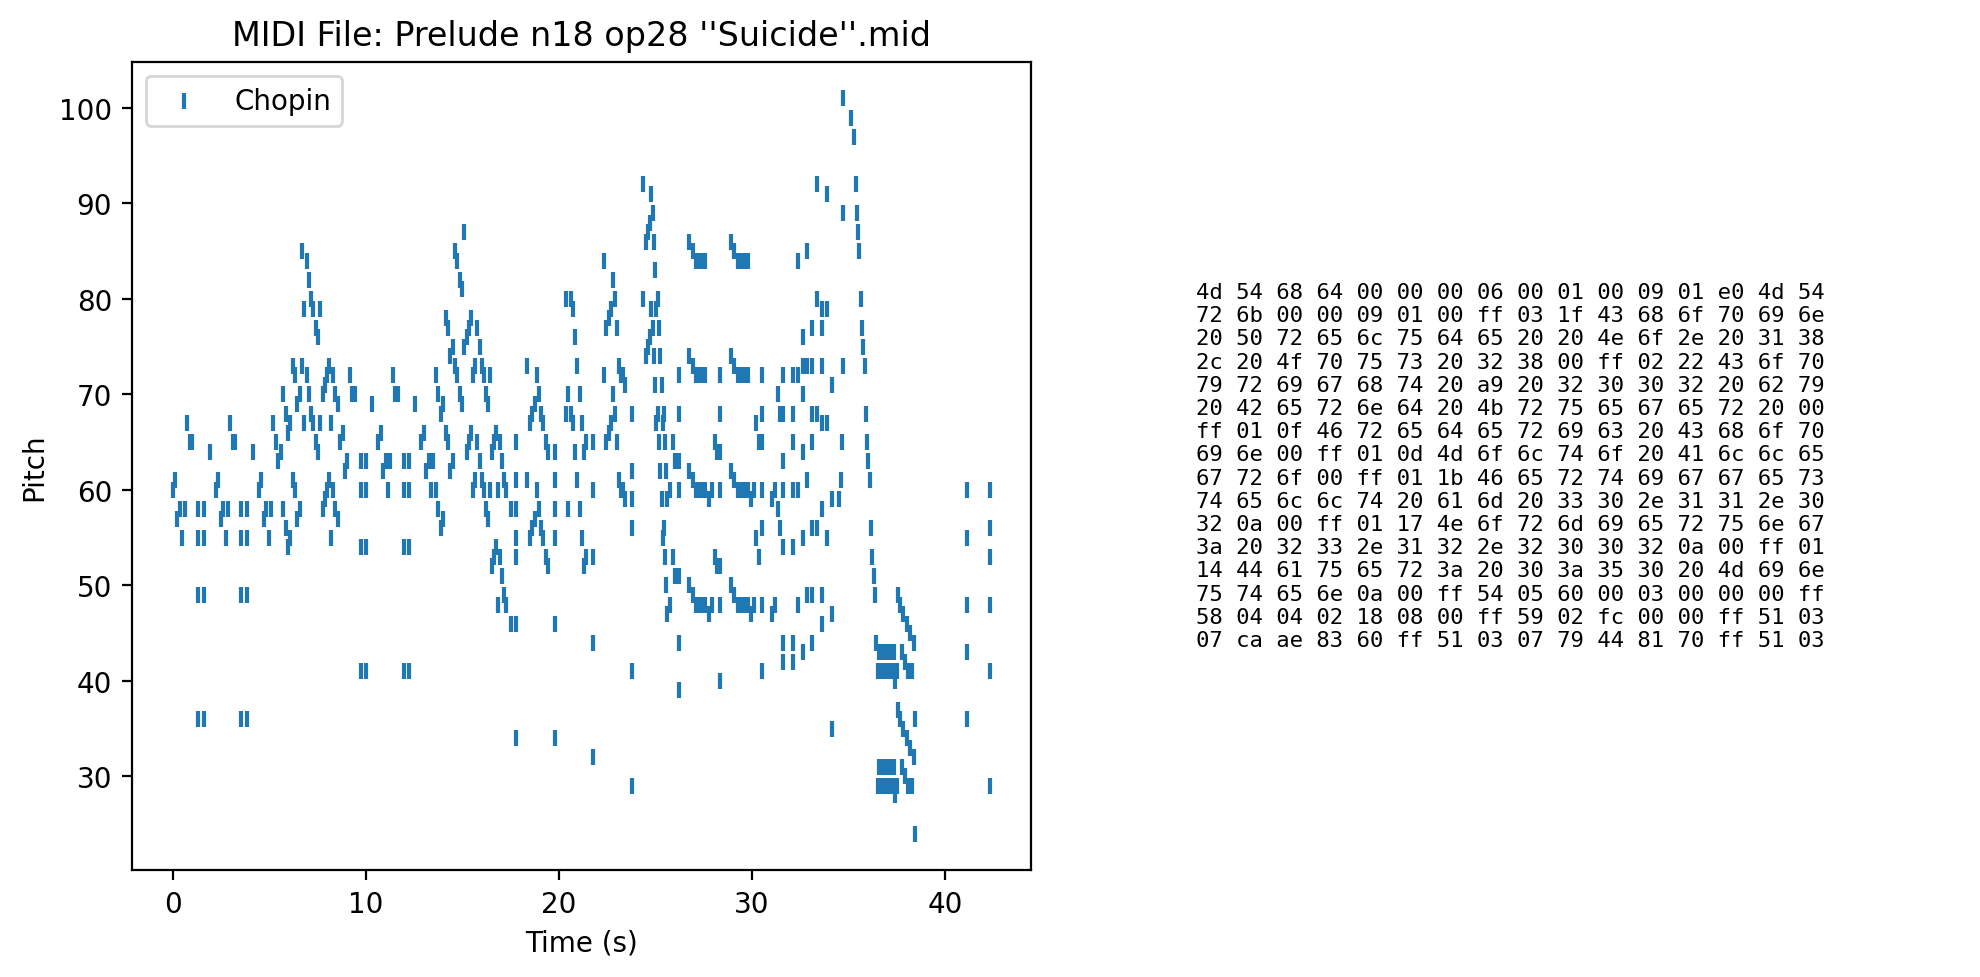

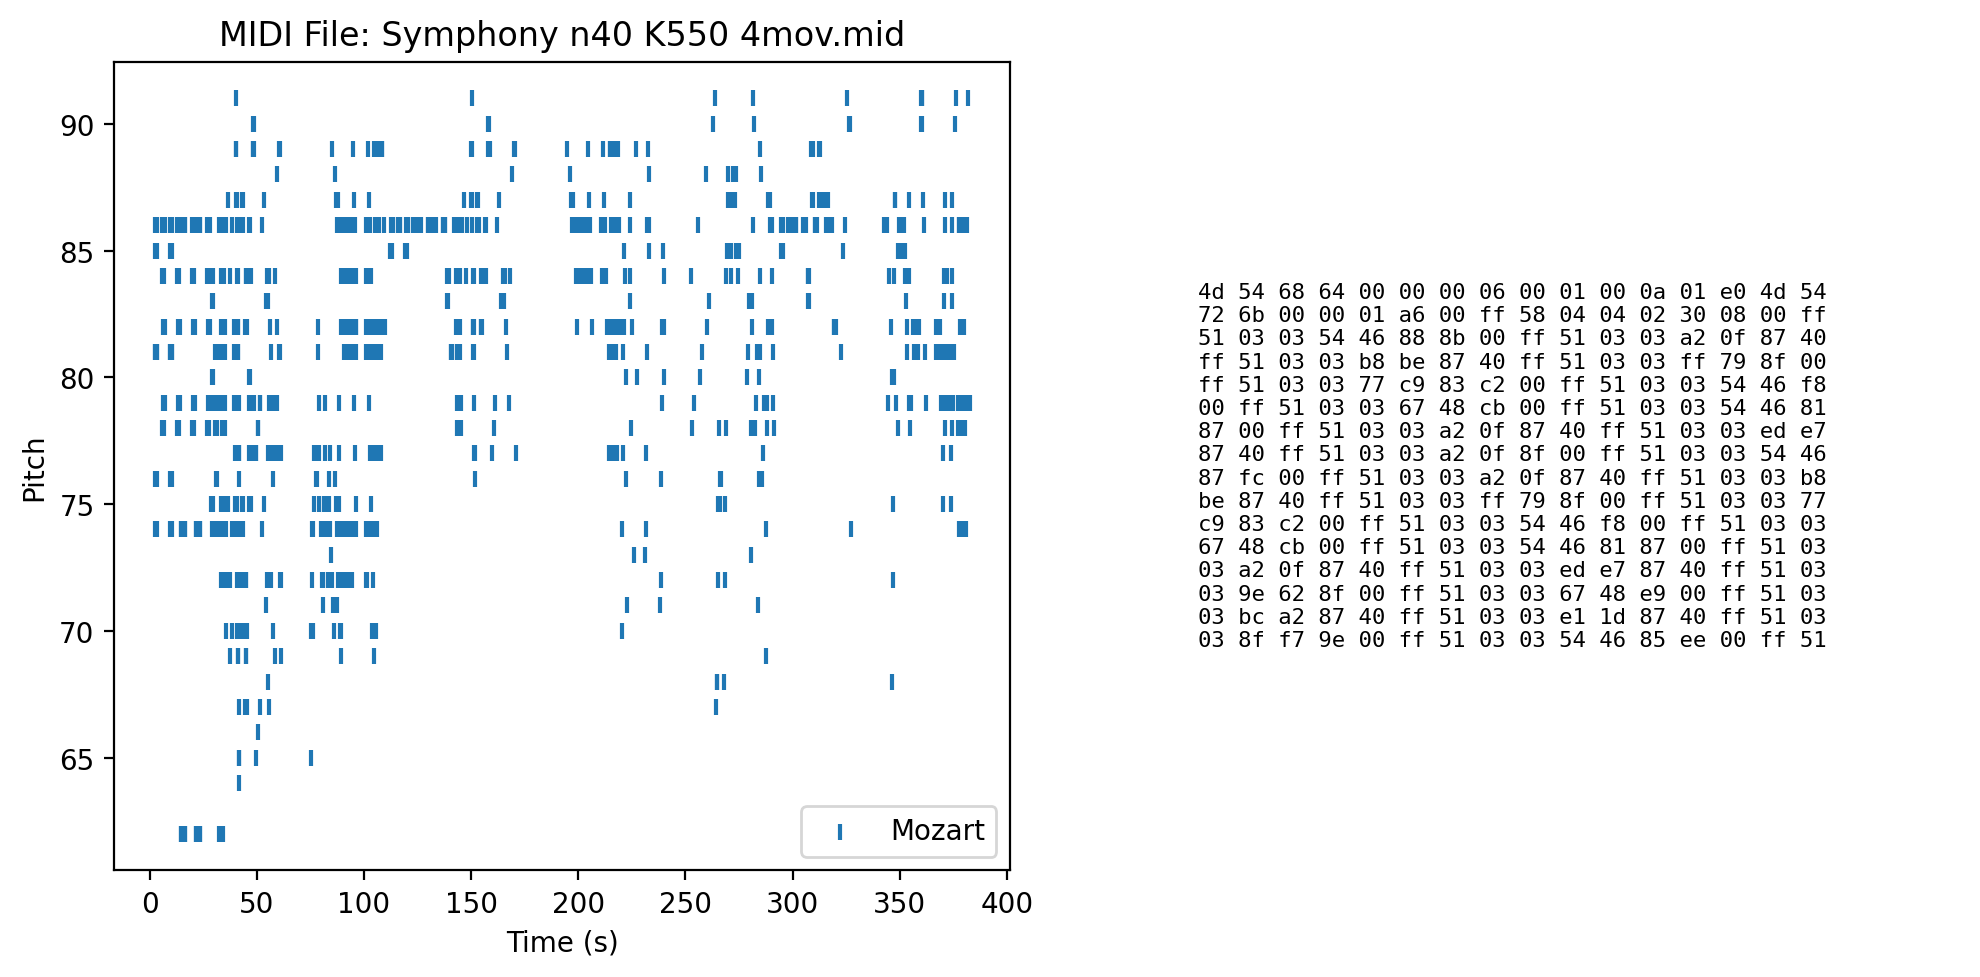

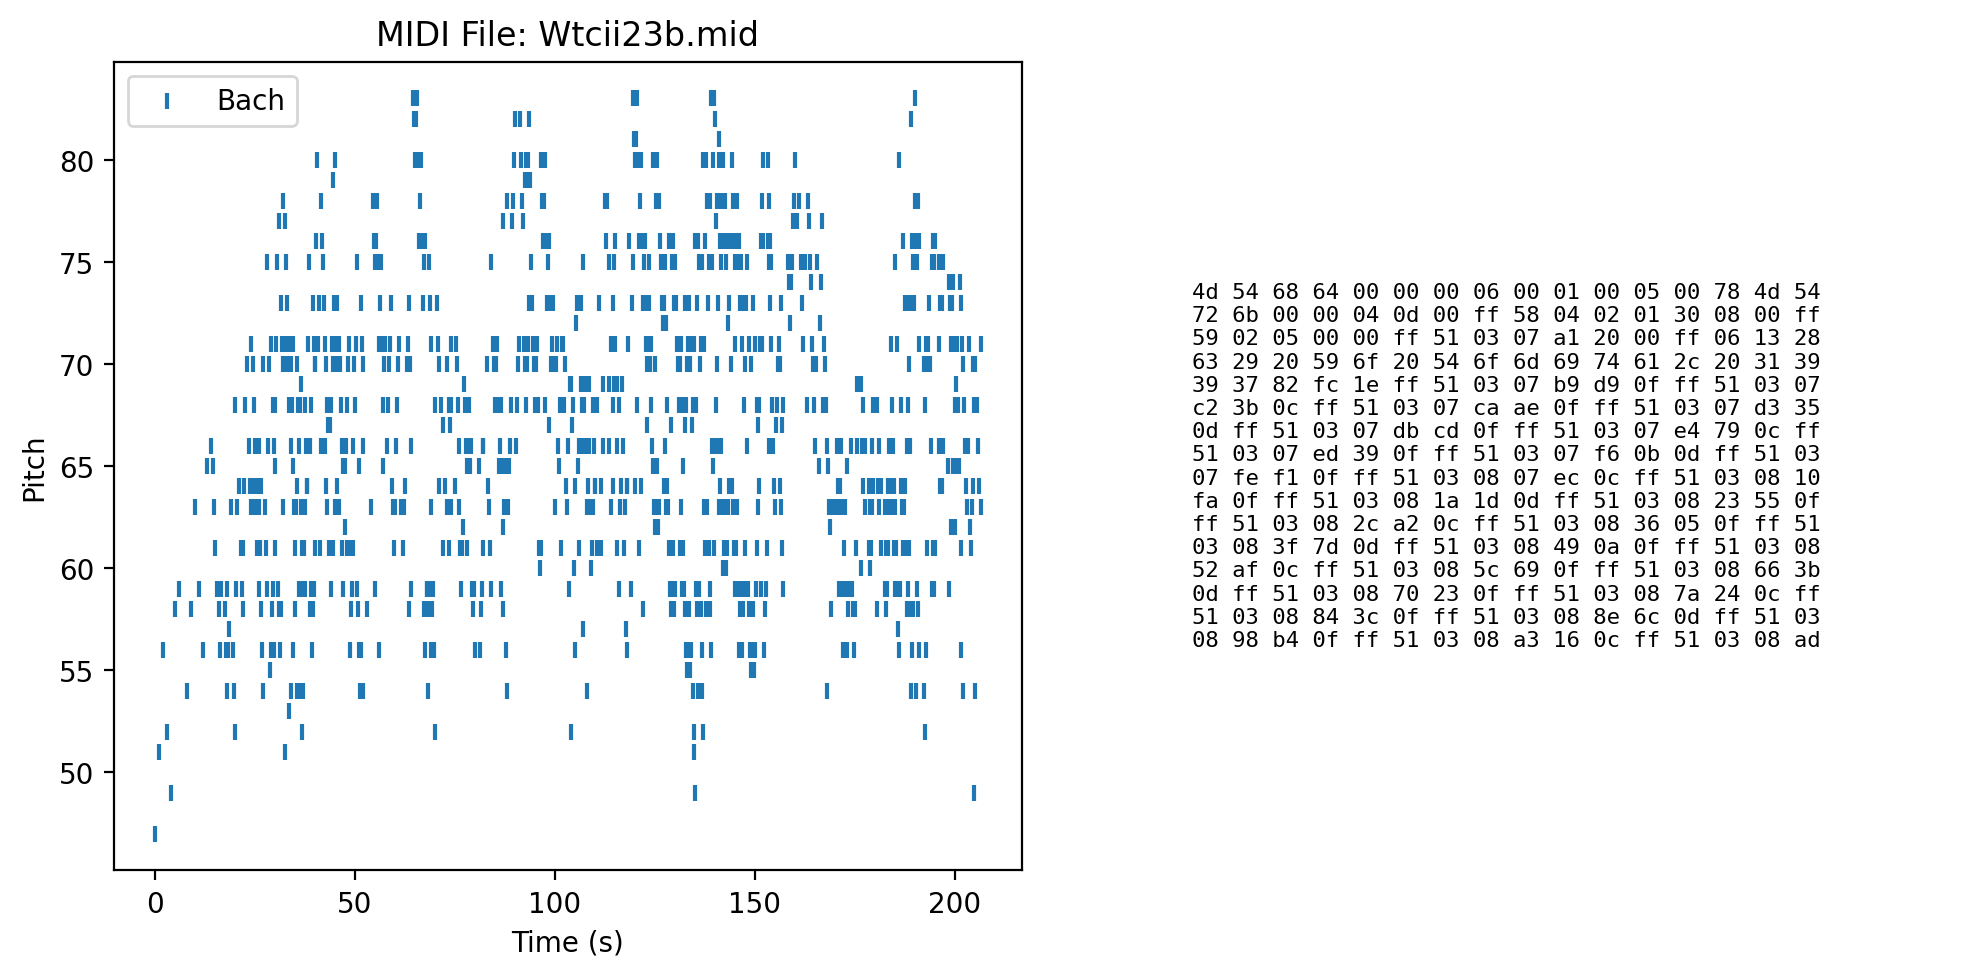

PDF saved to /content/drive/My Drive/AAI_511_NN/midi_notes_and_hex.pdf


In [19]:
def extract_notes(midi_file, max_notes=1000):
    """Extracts notes from a MIDI file using pretty_midi and limits to max_notes."""
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                notes.append((note.start, note.end, note.pitch))
                if len(notes) >= max_notes:
                    return notes
    return notes

def plot_midi_notes(notes, title, composer, ax):
    """Plots the notes of a MIDI file with composer label on the given axis."""
    start_times = [note[0] for note in notes]
    pitches = [note[2] for note in notes]

    ax.scatter(start_times, pitches, marker='|', label=composer)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pitch')
    ax.legend()

def display_hex(midi_file, ax, max_bytes=256):
    """Displays the hexadecimal representation of the MIDI file on the given axis."""
    with open(midi_file, 'rb') as f:
        content = f.read()
    hex_content = content[:max_bytes].hex()

    # Format the hex content for display
    hex_lines = [hex_content[i:i+32] for i in range(0, len(hex_content), 32)]
    formatted_hex = '\n'.join([' '.join([hex_line[j:j+2] for j in range(0, len(hex_line), 2)]) for hex_line in hex_lines])

    ax.text(0.5, 0.5, formatted_hex, fontsize=8, fontfamily='monospace', verticalalignment='center', horizontalalignment='center')
    ax.axis('off')

# Get list of subdirectories (each representing a composer)
composers = [name for name in os.listdir(extraction_dir) if os.path.isdir(os.path.join(extraction_dir, name))]

# Define the number of files to process per composer to avoid large plots
files_per_composer = 1  # Limit to 1 MIDI file per composer

# Create a PDF file
pdf_path = os.path.join(base_dir, 'midi_notes_and_hex.pdf')
with PdfPages(pdf_path) as pdf:
    for composer in composers:
        composer_dir = os.path.join(extraction_dir, composer)
        midi_files = [os.path.join(composer_dir, f) for f in os.listdir(composer_dir) if f.endswith(('.mid', '.MID'))]

        for midi_file in midi_files[:files_per_composer]:  # Limit to first file per composer
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            notes = extract_notes(midi_file)
            plot_midi_notes(notes, f"MIDI File: {os.path.basename(midi_file)}", composer, axs[0])
            display_hex(midi_file, axs[1])

            plt.tight_layout()
            pdf.savefig(fig)
            plt.show()
            plt.close(fig)

print(f"PDF saved to {pdf_path}")


### Statistical Normality Tests for MIDI Features

#### Overview

This section performs statistical normality tests on the extracted features from MIDI files. The tests used are Shapiro-Wilk, Anderson-Darling, and Kolmogorov-Smirnov. The results are summarized in a table, and conclusions are drawn based on the test outcomes.

#### Features Tested

The following features are tested for normality:

1. Low-level Features:

  - RMS (Root Mean Square) of velocities
  - Spectral Flux of velocities
  - Zero Crossing Rate of velocities

2. High-level Features:

  - Note Sequence
  - Duration
  - Tempo
  - Time Signature (numerator and denominator)
  - Key Signature
  - Average Velocity
  - Maximum Velocity
  - Minimum Velocity
  - Velocity Standard Deviation
  - Pitch Range
  - Number of Instruments
  - Note Density
  - Number of Notes
  - Average Pitch
  - Maximum Pitch
  - Minimum Pitch
  - Pitch Standard Deviation
  - Number of Articulations

#### Statistical Tests

1. **Shapiro-Wilk Test**: Tests the null hypothesis that the data was drawn from a normal distribution.
2. **Anderson-Darling Test**: A statistical test of whether a given sample of data is drawn from a given probability distribution.
3. **Kolmogorov-Smirnov Test**: Compares the sample distribution with the normal distribution.


In [21]:
# Load the extracted features dataset
df = pd.read_csv(os.path.join(base_dir,'standardized_midi_features.csv')

# Define the features to transform
features_to_transform = [
    'duration', 'tempo', 'average_velocity', 'max_velocity',
    'min_velocity', 'velocity_std', 'pitch_range', 'num_instruments',
    'note_density', 'num_notes', 'average_pitch', 'max_pitch',
    'min_pitch', 'pitch_std', 'articulations', 'rms', 'spectral_flux', 'zero_crossing_rate'
]

# Perform Shapiro-Wilk test
shapiro_results = []
for feature in features_to_transform:
    stat, p = shapiro(df[feature])
    shapiro_results.append((feature, stat, p))

# Perform Anderson-Darling test
anderson_results = []
for feature in features_to_transform:
    result = anderson(df[feature])
    anderson_results.append((feature, result.statistic, result.critical_values))

# Perform Kolmogorov-Smirnov test
kstest_results = []
for feature in features_to_transform:
    stat, p = kstest(df[feature], 'norm')
    kstest_results.append((feature, stat, p))

# Create a summary table
summary_table = pd.DataFrame({
    'Feature': features_to_transform,
    'Shapiro-Wilk Statistic': [res[1] for res in shapiro_results],
    'Shapiro-Wilk p-value': [res[2] for res in shapiro_results],
    'Anderson-Darling Statistic': [res[1] for res in anderson_results],
    'Anderson-Darling Critical Values': [res[2] for res in anderson_results],
    'Kolmogorov-Smirnov Statistic': [res[1] for res in kstest_results],
    'Kolmogorov-Smirnov p-value': [res[2] for res in kstest_results]
})

# Print the summary table
print(summary_table)

# Conclusions based on the p-values and critical values
conclusions = []
for index, row in summary_table.iterrows():
    shapiro_conclusion = "Non-Normal" if row['Shapiro-Wilk p-value'] < 0.05 else "Normal"
    anderson_conclusion = "Non-Normal" if row['Anderson-Darling Statistic'] > row['Anderson-Darling Critical Values'][2] else "Normal" # Using the 5% significance level
    kstest_conclusion = "Non-Normal" if row['Kolmogorov-Smirnov p-value'] < 0.05 else "Normal"
    conclusions.append((row['Feature'], shapiro_conclusion, anderson_conclusion, kstest_conclusion))

# Create a conclusions table
conclusions_table = pd.DataFrame(conclusions, columns=['Feature', 'Shapiro-Wilk Conclusion', 'Anderson-Darling Conclusion', 'Kolmogorov-Smirnov Conclusion'])

# Print the conclusions table
print(conclusions_table)


               Feature  Shapiro-Wilk Statistic  Shapiro-Wilk p-value  \
0             duration                0.624035          9.312882e-51   
1                tempo                0.986657          3.778683e-11   
2     average_velocity                0.915656          3.037993e-29   
3         max_velocity                0.905432          1.129726e-30   
4         min_velocity                0.885724          4.060186e-33   
5         velocity_std                0.799840          6.204851e-41   
6          pitch_range                0.967658          1.119874e-18   
7      num_instruments                0.739162          6.305919e-45   
8         note_density                0.742006          9.309392e-45   
9            num_notes                0.625938          1.128554e-50   
10       average_pitch                0.990149          4.649008e-09   
11           max_pitch                0.964436          1.302174e-19   
12           min_pitch                0.965911          3.424094

### Results Summary

Above generated summarizing the statistics and p-values for each test across all features. Conclusions are drawn based on the p-values and critical values:

- **Shapiro-Wilk Conclusion**: Determined as "Normal" if p-value > 0.05, otherwise "Non-Normal".
- **Anderson-Darling Conclusion**: Determined as "Normal" if the test statistic is less than the critical value at the 5% significance level, otherwise "Non-Normal".
- **Kolmogorov-Smirnov Conclusion**: Determined as "Normal" if p-value > 0.05, otherwise "Non-Normal".



### MIDI Feature Extraction and Preprocessing for Machine Learning

#### Overview

This provides a comprehensive pipeline for extracting, standardizing, and preparing various features from MIDI files for machine learning.

#### Features Extracted

The following features are extracted from each MIDI file:

1. Low-level Features:

  - RMS (Root Mean Square) of velocities
  - Spectral Flux of velocities
  - Zero Crossing Rate of velocities

2. High-level Features:

  - Note Sequence
  - Duration
  - Tempo
  - Time Signature (numerator and denominator)
  - Key Signature
  - Average Velocity
  - Maximum Velocity
  - Minimum Velocity
  - Velocity Standard Deviation
  - Pitch Range
  - Number of Instruments
  - Note Density
  - Number of Notes
  - Average Pitch
  - Maximum Pitch
  - Minimum Pitch
  - Pitch Standard Deviation
  - Number of Articulations

#### Data Preprocessing Steps

1. **Load Extracted Features**: Load the CSV file containing the extracted features.
2. **Format Note Sequences**: Ensure the note sequences are correctly formatted as lists.
3. **Standardize Features**: Standardize numerical features using `StandardScaler` from `sklearn` to ensure they have a mean of 0 and a standard deviation of 1.
4. **Encode Target Labels**: Encode the target labels (composers) using `LabelEncoder` and convert them to categorical format using `to_categorical`.
5. **Pad Note Sequences**: Pad the note sequences to a uniform length (`max_len`) using `pad_sequences`.
6. **Prepare Input Features**: For each feature, expand its dimensions and repeat it to match the sequence length. Stack all features together along with the note sequences.
7. **Split Data**: Split the dataset into training and validation sets using `train_test_split`.

This ensures that the data is prepared appropriately for input into machine learning models, facilitating effective training and evaluation.

In [22]:
# Load the extracted features dataset
df = pd.read_csv(os.path.join(base_dir,'extracted_midi_features.csv'))

# Ensure the note sequences are properly formatted
df['note_sequence'] = df['note_sequence'].apply(eval)

# Standardize the features
features_to_standardize = [
    'duration', 'tempo', 'average_velocity', 'max_velocity',
    'min_velocity', 'velocity_std', 'pitch_range', 'num_instruments',
    'note_density', 'num_notes', 'average_pitch', 'max_pitch',
    'min_pitch', 'pitch_std', 'articulations'
]

scaler = StandardScaler()
df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

# Encode the target labels
label_encoder = LabelEncoder()
encoded_composers = label_encoder.fit_transform(df['composer'])
categorical_composers = to_categorical(encoded_composers)

# Pad the note sequences to ensure uniform length
max_len = 100  # Define a maximum length for padding
note_sequences = pad_sequences(df['note_sequence'], maxlen=max_len, padding='post')

# Prepare the input features
features = [
    'duration', 'tempo', 'average_velocity', 'max_velocity',
    'min_velocity', 'velocity_std', 'pitch_range', 'num_instruments',
    'note_density', 'num_notes', 'average_pitch', 'max_pitch',
    'min_pitch', 'pitch_std', 'articulations'
]
feature_arrays = []

for feature in features:
    feature_values = np.expand_dims(df[feature].values, axis=1)
    feature_values = np.repeat(feature_values, max_len, axis=1)
    feature_arrays.append(feature_values)

# Stack the features together along with the note sequences
X = np.concatenate([np.expand_dims(note_sequences, axis=-1)] + [np.expand_dims(f, axis=-1) for f in feature_arrays], axis=-1)
y = categorical_composers

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(1308, 100, 16)
(327, 100, 16)
(1308, 4)
(327, 4)


#### Data Split Summary
The data split resulted in the following shapes:

- Training Features (X_train): (1308, 100, 16)
- Validation Features (X_val): (327, 100, 16)
- Training Labels (y_train): (1308, 4)
- Validation Labels (y_val): (327, 4)

## LSTM Model for Composer Classification

### Overview

This section outlines the implementation of an LSTM (Long Short-Term Memory) model for classifying music composers based on features extracted from MIDI files. The model leverages various hyperparameters, and a grid search is conducted to identify the optimal configuration for the best performance.

### LSTM Model Architecture

The LSTM model is designed with the following layers:

1. **Input Layer**: Accepts sequences of shape `(max_len, 1)`.
2. **Bidirectional LSTM Layer**: Processes the input sequences in both forward and backward directions with `lstm_units` units.
3. **Dropout Layer**: Prevents overfitting by randomly dropping `dropout_rate` proportion of units.
4. **Batch Normalization Layer**: Normalizes the activations of the previous layer.
5. **Attention Mechanism**: Implements an attention mechanism to focus on important parts of the sequence.
6. **Second Bidirectional LSTM Layer**: Further processes the sequences with `lstm_units` units.
7. **Second Dropout Layer**: Prevents overfitting by randomly dropping `dropout_rate` proportion of units.
8. **Second Batch Normalization Layer**: Normalizes the activations of the previous layer.
9. **Dense Layer**: Fully connected layer with 128 units and ReLU activation.
10. **Third Dropout Layer**: Prevents overfitting by randomly dropping `dropout_rate` proportion of units.
11. **Output Layer**: Fully connected layer with softmax activation for classification.

### Hyperparameter Tuning

A grid search is conducted over the following hyperparameters to find the best configuration:
- **Optimizer**: ['adam', 'rmsprop', 'nadam']
- **Learning Rate**: [0.001, 0.01, 0.1]
- **LSTM Units**: [64, 128, 256]
- **Dropout Rate**: [0.1, 0.2, 0.3]
- **Batch Size**: [8, 32, 64]
- **Epochs**: [10, 20, 50, 100]

### Training Process

1. **Model Building**: The model is built using the specified hyperparameters.
2. **Callbacks**: Various callbacks are used, including early stopping, learning rate reduction on plateau, and learning rate scheduler.
3. **Progress Monitoring**: The `TqdmCallback` provides a progress bar to monitor the training process.
4. **Evaluation**: Each model configuration is evaluated on the validation set, and the best configuration is selected based on validation accuracy.

In [ ]:
# Encode the target labels
label_encoder = LabelEncoder()
encoded_composers = label_encoder.fit_transform(df['composer'])
categorical_composers = to_categorical(encoded_composers)

# Pad the note sequences to ensure uniform length
max_len = 100
note_sequences = pad_sequences(df['note_sequence'], maxlen=max_len, padding='post')

# Normalize the input features
note_sequences = note_sequences / np.max(note_sequences)

# Prepare the input features
X = note_sequences
y = encoded_composers  # Use encoded_composers instead of categorical_composers for SMOTE

# Reshape X for SMOTE (SMOTE does not accept 3D arrays)
X_reshaped = X.reshape((X.shape[0], X.shape[1]))

# Apply SMOTE to balance the data
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X_reshaped, y)

# Reshape X_balanced back to 3D array
X_balanced = X_balanced.reshape((X_balanced.shape[0], X.shape[1], 1))

# Convert y_balanced back to categorical
y_balanced = to_categorical(y_balanced)

# Split the balanced data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

def build_model(optimizer='adam', learning_rate=0.001, lstm_units=64, dropout_rate=0.3):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)

    inputs = Input(shape=(max_len, 1))
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = attention_3d_block(x)
    x = Bidirectional(LSTM(lstm_units))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(max_len, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

class TqdmCallback(Callback):
    def __init__(self, pbar):
        self.pbar = pbar

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(accuracy=f"{logs['accuracy']:.4f}", loss=f"{logs['loss']:.4f}", val_accuracy=f"{logs['val_accuracy']:.4f}", val_loss=f"{logs['val_loss']:.4f}")

# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam'], #Other optmizers: 'rmsprop', 'nadam'
    'learning_rate': [0.001, 0.01, 0.1],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [16, 32, 64],
    'epochs': [20, 50, 100]
}

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

# Create a list to store the results
results = []

# Perform grid search manually
for optimizer, learning_rate, lstm_units, dropout_rate, batch_size, epochs in product(param_grid['optimizer'],
                                                                                     param_grid['learning_rate'],
                                                                                     param_grid['lstm_units'],
                                                                                     param_grid['dropout_rate'],
                                                                                     param_grid['batch_size'],
                                                                                     param_grid['epochs']):
    print(f"Training with optimizer={optimizer}, lstm_units={lstm_units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")
    model = build_model(optimizer=optimizer, learning_rate=learning_rate, lstm_units=lstm_units, dropout_rate=dropout_rate)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model with progress bar
    with tqdm(total=epochs, colour='green') as pbar:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr, lr_scheduler, TqdmCallback(pbar)], verbose=0)

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    results.append((optimizer, learning_rate, lstm_units, dropout_rate, batch_size, epochs, val_accuracy))
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Find the best hyperparameters
best_params = max(results, key=lambda x: x[6])
print(f"Best hyperparameters: optimizer={best_params[0]}, learning_rate={best_params[1]}, lstm_units={best_params[2]}, dropout_rate={best_params[3]}, batch_size={best_params[4]}, epochs={best_params[5]} with Validation Accuracy={best_params[6] * 100:.2f}%")

# Train the best model
best_model = build_model(optimizer=best_params[0], learning_rate=best_params[1], lstm_units=best_params[2], dropout_rate=best_params[3])
with tqdm(total=best_params[5]) as pbar:
    history = best_model.fit(X_train, y_train, epochs=best_params[5], batch_size=best_params[4], validation_data=(X_val, y_val),
                             callbacks=[early_stopping, reduce_lr, lr_scheduler, TqdmCallback(pbar)], verbose=0)

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:38<00:00,  4.95s/it, accuracy=0.7131, loss=0.7063, val_accuracy=0.6976, val_loss=0.7500]


Validation Accuracy: 69.15%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=16, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [03:51<00:00,  4.62s/it, accuracy=0.7915, loss=0.5354, val_accuracy=0.7854, val_loss=0.6257]


Validation Accuracy: 78.66%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=16, epochs=100, learning_rate=0.001


 62%|██████▏   | 62/100 [04:44<02:54,  4.59s/it, accuracy=0.8129, loss=0.4713, val_accuracy=0.7927, val_loss=0.5432]


Validation Accuracy: 79.39%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:50<00:00,  2.55s/it, accuracy=0.6505, loss=0.8347, val_accuracy=0.6183, val_loss=0.9218]


Validation Accuracy: 64.51%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [02:00<00:00,  2.41s/it, accuracy=0.7680, loss=0.6069, val_accuracy=0.7451, val_loss=0.6965]


Validation Accuracy: 74.39%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=32, epochs=100, learning_rate=0.001


 75%|███████▌  | 75/100 [02:59<00:59,  2.39s/it, accuracy=0.7982, loss=0.5304, val_accuracy=0.7524, val_loss=0.6331]


Validation Accuracy: 75.61%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:28<00:00,  1.45s/it, accuracy=0.5440, loss=1.0543, val_accuracy=0.5159, val_loss=1.0710]


Validation Accuracy: 51.59%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, accuracy=0.5281, loss=1.0889, val_accuracy=0.5329, val_loss=1.0868]


Validation Accuracy: 53.05%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=64, epochs=100, learning_rate=0.001


 73%|███████▎  | 73/100 [01:32<00:34,  1.27s/it, accuracy=0.5287, loss=1.0816, val_accuracy=0.5244, val_loss=1.0900]


Validation Accuracy: 52.44%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:36<00:00,  4.83s/it, accuracy=0.6374, loss=0.8732, val_accuracy=0.6256, val_loss=0.9017]


Validation Accuracy: 61.46%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [03:50<00:00,  4.61s/it, accuracy=0.7207, loss=0.6713, val_accuracy=0.7402, val_loss=0.6967]


Validation Accuracy: 74.02%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.001


 76%|███████▌  | 76/100 [05:49<01:50,  4.60s/it, accuracy=0.7253, loss=0.7012, val_accuracy=0.7220, val_loss=0.6998]


Validation Accuracy: 72.56%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:50<00:00,  2.55s/it, accuracy=0.6157, loss=0.9152, val_accuracy=0.5854, val_loss=0.9612]


Validation Accuracy: 58.54%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [02:01<00:00,  2.44s/it, accuracy=0.7131, loss=0.7095, val_accuracy=0.7061, val_loss=0.7465]


Validation Accuracy: 70.61%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=32, epochs=100, learning_rate=0.001


 69%|██████▉   | 69/100 [02:44<01:13,  2.38s/it, accuracy=0.6920, loss=0.7586, val_accuracy=0.6780, val_loss=0.8080]


Validation Accuracy: 67.44%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:28<00:00,  1.44s/it, accuracy=0.5632, loss=1.0354, val_accuracy=0.5561, val_loss=1.0249]


Validation Accuracy: 55.61%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:04<00:00,  1.29s/it, accuracy=0.5147, loss=1.1309, val_accuracy=0.4988, val_loss=1.1207]


Validation Accuracy: 49.88%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=64, epochs=100, learning_rate=0.001


 89%|████████▉ | 89/100 [01:52<00:13,  1.27s/it, accuracy=0.6426, loss=0.8788, val_accuracy=0.6195, val_loss=0.9217]


Validation Accuracy: 62.20%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:37<00:00,  4.86s/it, accuracy=0.5690, loss=1.0133, val_accuracy=0.5500, val_loss=1.0546]


Validation Accuracy: 54.63%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=16, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [03:50<00:00,  4.61s/it, accuracy=0.6050, loss=0.9356, val_accuracy=0.6134, val_loss=0.9152]


Validation Accuracy: 61.34%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=16, epochs=100, learning_rate=0.001


 68%|██████▊   | 68/100 [05:13<02:27,  4.61s/it, accuracy=0.6438, loss=0.8529, val_accuracy=0.6280, val_loss=0.8678]


Validation Accuracy: 62.56%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:51<00:00,  2.56s/it, accuracy=0.5308, loss=1.0945, val_accuracy=0.4878, val_loss=1.1642]


Validation Accuracy: 53.90%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [02:02<00:00,  2.44s/it, accuracy=0.6078, loss=0.9388, val_accuracy=0.5939, val_loss=0.9515]


Validation Accuracy: 59.76%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=32, epochs=100, learning_rate=0.001


 70%|███████   | 70/100 [02:47<01:11,  2.39s/it, accuracy=0.5955, loss=0.9356, val_accuracy=0.5927, val_loss=0.9344]


Validation Accuracy: 59.63%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:30<00:00,  1.52s/it, accuracy=0.4780, loss=1.2158, val_accuracy=0.4768, val_loss=1.1963]


Validation Accuracy: 47.68%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:06<00:00,  1.32s/it, accuracy=0.5611, loss=1.0046, val_accuracy=0.5549, val_loss=1.0181]


Validation Accuracy: 55.61%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=64, epochs=100, learning_rate=0.001


 68%|██████▊   | 68/100 [01:26<00:40,  1.27s/it, accuracy=0.4249, loss=1.2468, val_accuracy=0.4354, val_loss=1.2481]


Validation Accuracy: 43.54%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:37<00:00,  4.86s/it, accuracy=0.7491, loss=0.6131, val_accuracy=0.7390, val_loss=0.7095]


Validation Accuracy: 72.93%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=16, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [03:52<00:00,  4.64s/it, accuracy=0.8977, loss=0.2843, val_accuracy=0.8622, val_loss=0.4576]


Validation Accuracy: 85.98%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=16, epochs=100, learning_rate=0.001


 49%|████▉     | 49/100 [03:51<04:01,  4.73s/it, accuracy=0.8739, loss=0.3497, val_accuracy=0.8220, val_loss=0.5594]


Validation Accuracy: 82.20%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:51<00:00,  2.56s/it, accuracy=0.7411, loss=0.6751, val_accuracy=0.6829, val_loss=0.8171]


Validation Accuracy: 69.76%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:55<00:00,  2.31s/it, accuracy=0.8117, loss=0.4821, val_accuracy=0.8049, val_loss=0.5868]


Validation Accuracy: 80.12%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=32, epochs=100, learning_rate=0.001


 80%|████████  | 80/100 [03:05<00:46,  2.32s/it, accuracy=0.8706, loss=0.3602, val_accuracy=0.8244, val_loss=0.5043]


Validation Accuracy: 82.44%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:27<00:00,  1.38s/it, accuracy=0.5409, loss=1.0572, val_accuracy=0.5341, val_loss=1.0742]


Validation Accuracy: 53.54%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:03<00:00,  1.26s/it, accuracy=0.5632, loss=1.0279, val_accuracy=0.5329, val_loss=1.0498]


Validation Accuracy: 53.41%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=64, epochs=100, learning_rate=0.001


 51%|█████     | 51/100 [01:04<01:02,  1.27s/it, accuracy=0.5720, loss=1.0098, val_accuracy=0.5488, val_loss=1.0389]


Validation Accuracy: 54.88%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:39<00:00,  4.96s/it, accuracy=0.6746, loss=0.7894, val_accuracy=0.6927, val_loss=0.7809]


Validation Accuracy: 69.27%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [03:57<00:00,  4.74s/it, accuracy=0.8028, loss=0.4878, val_accuracy=0.7768, val_loss=0.5699]


Validation Accuracy: 77.68%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.001


 83%|████████▎ | 83/100 [06:28<01:19,  4.68s/it, accuracy=0.7848, loss=0.5694, val_accuracy=0.7659, val_loss=0.6635]


Validation Accuracy: 76.95%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:49<00:00,  2.48s/it, accuracy=0.6129, loss=0.9222, val_accuracy=0.5695, val_loss=0.9881]


Validation Accuracy: 61.34%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:57<00:00,  2.36s/it, accuracy=0.7677, loss=0.5974, val_accuracy=0.7427, val_loss=0.6881]


Validation Accuracy: 74.76%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=32, epochs=100, learning_rate=0.001


 56%|█████▌    | 56/100 [02:13<01:44,  2.38s/it, accuracy=0.7561, loss=0.6173, val_accuracy=0.7488, val_loss=0.7010]


Validation Accuracy: 74.76%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:28<00:00,  1.41s/it, accuracy=0.6081, loss=0.9505, val_accuracy=0.5744, val_loss=0.9724]


Validation Accuracy: 57.44%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:02<00:00,  1.26s/it, accuracy=0.5198, loss=1.1221, val_accuracy=0.5268, val_loss=1.1137]


Validation Accuracy: 52.68%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=64, epochs=100, learning_rate=0.001


 71%|███████   | 71/100 [01:27<00:35,  1.24s/it, accuracy=0.5272, loss=1.1031, val_accuracy=0.5207, val_loss=1.1005]


Validation Accuracy: 52.07%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:37<00:00,  4.90s/it, accuracy=0.6285, loss=0.9050, val_accuracy=0.6671, val_loss=0.8277]


Validation Accuracy: 66.71%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=16, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [03:55<00:00,  4.71s/it, accuracy=0.7405, loss=0.6590, val_accuracy=0.7280, val_loss=0.7122]


Validation Accuracy: 72.80%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=16, epochs=100, learning_rate=0.001


 73%|███████▎  | 73/100 [05:45<02:07,  4.73s/it, accuracy=0.6758, loss=0.7745, val_accuracy=0.6732, val_loss=0.8317]


Validation Accuracy: 67.56%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:50<00:00,  2.51s/it, accuracy=0.5647, loss=1.0146, val_accuracy=0.5720, val_loss=0.9960]


Validation Accuracy: 57.20%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:56<00:00,  2.33s/it, accuracy=0.7128, loss=0.7035, val_accuracy=0.6951, val_loss=0.7619]


Validation Accuracy: 70.24%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=32, epochs=100, learning_rate=0.001


 90%|█████████ | 90/100 [03:22<00:22,  2.25s/it, accuracy=0.6960, loss=0.7427, val_accuracy=0.6902, val_loss=0.7788]


Validation Accuracy: 69.27%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:30<00:00,  1.50s/it, accuracy=0.5580, loss=1.0423, val_accuracy=0.5427, val_loss=1.0583]


Validation Accuracy: 54.27%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:03<00:00,  1.27s/it, accuracy=0.6368, loss=0.8852, val_accuracy=0.6085, val_loss=0.9366]


Validation Accuracy: 60.49%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=64, epochs=100, learning_rate=0.001


 96%|█████████▌| 96/100 [01:54<00:04,  1.19s/it, accuracy=0.6380, loss=0.8820, val_accuracy=0.6293, val_loss=0.9009]


Validation Accuracy: 62.68%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:30<00:00,  4.55s/it, accuracy=0.4863, loss=1.1809, val_accuracy=0.4244, val_loss=1.2893]


Validation Accuracy: 49.02%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=16, epochs=50, learning_rate=0.001


 92%|█████████▏| 46/50 [03:24<00:17,  4.45s/it, accuracy=0.9301, loss=0.2083, val_accuracy=0.8695, val_loss=0.4640]


Validation Accuracy: 85.98%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=16, epochs=100, learning_rate=0.001


 59%|█████▉    | 59/100 [04:18<02:59,  4.38s/it, accuracy=0.5098, loss=1.1214, val_accuracy=0.5207, val_loss=1.1051]


Validation Accuracy: 52.07%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:50<00:00,  2.53s/it, accuracy=0.7598, loss=0.6233, val_accuracy=0.7183, val_loss=0.7458]


Validation Accuracy: 73.29%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:57<00:00,  2.34s/it, accuracy=0.8987, loss=0.2863, val_accuracy=0.8476, val_loss=0.4624]


Validation Accuracy: 83.66%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=32, epochs=100, learning_rate=0.001


 47%|████▋     | 47/100 [01:48<02:02,  2.31s/it, accuracy=0.9341, loss=0.1936, val_accuracy=0.8732, val_loss=0.4479]


Validation Accuracy: 87.07%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:30<00:00,  1.51s/it, accuracy=0.7161, loss=0.7211, val_accuracy=0.6817, val_loss=0.8265]


Validation Accuracy: 68.17%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:08<00:00,  1.37s/it, accuracy=0.8587, loss=0.3934, val_accuracy=0.8256, val_loss=0.5569]


Validation Accuracy: 82.56%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.1, batch_size=64, epochs=100, learning_rate=0.001


 58%|█████▊    | 58/100 [01:18<00:56,  1.36s/it, accuracy=0.6215, loss=0.9409, val_accuracy=0.5951, val_loss=0.9913]


Validation Accuracy: 59.51%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:31<00:00,  4.55s/it, accuracy=0.6236, loss=0.8935, val_accuracy=0.6280, val_loss=0.9417]


Validation Accuracy: 62.80%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [03:49<00:00,  4.60s/it, accuracy=0.8605, loss=0.3627, val_accuracy=0.8451, val_loss=0.4865]


Validation Accuracy: 84.51%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.001


 79%|███████▉  | 79/100 [05:57<01:35,  4.52s/it, accuracy=0.5171, loss=1.1260, val_accuracy=0.5037, val_loss=1.1348]


Validation Accuracy: 50.24%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:49<00:00,  2.48s/it, accuracy=0.6517, loss=0.8482, val_accuracy=0.6463, val_loss=0.8662]


Validation Accuracy: 64.63%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:59<00:00,  2.39s/it, accuracy=0.7711, loss=0.6036, val_accuracy=0.7549, val_loss=0.6341]


Validation Accuracy: 75.49%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=32, epochs=100, learning_rate=0.001


 65%|██████▌   | 65/100 [02:34<01:23,  2.38s/it, accuracy=0.8739, loss=0.3460, val_accuracy=0.8415, val_loss=0.4984]


Validation Accuracy: 83.90%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:30<00:00,  1.54s/it, accuracy=0.5571, loss=1.0518, val_accuracy=0.5354, val_loss=1.0686]


Validation Accuracy: 54.39%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:08<00:00,  1.37s/it, accuracy=0.5482, loss=1.0583, val_accuracy=0.5341, val_loss=1.0725]


Validation Accuracy: 53.41%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.2, batch_size=64, epochs=100, learning_rate=0.001


 88%|████████▊ | 88/100 [01:58<00:16,  1.34s/it, accuracy=0.5556, loss=1.0370, val_accuracy=0.5427, val_loss=1.0559]


Validation Accuracy: 54.51%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=16, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [01:34<00:00,  4.72s/it, accuracy=0.5498, loss=1.0521, val_accuracy=0.5073, val_loss=1.1126]


Validation Accuracy: 51.59%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=16, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [03:44<00:00,  4.49s/it, accuracy=0.7268, loss=0.6708, val_accuracy=0.7207, val_loss=0.7164]


Validation Accuracy: 72.07%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=16, epochs=100, learning_rate=0.001


 62%|██████▏   | 62/100 [04:37<02:50,  4.47s/it, accuracy=0.8104, loss=0.4686, val_accuracy=0.7976, val_loss=0.5357]


Validation Accuracy: 80.12%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=32, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:49<00:00,  2.48s/it, accuracy=0.6126, loss=0.9193, val_accuracy=0.6000, val_loss=0.9646]


Validation Accuracy: 60.00%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=32, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:56<00:00,  2.33s/it, accuracy=0.7112, loss=0.7225, val_accuracy=0.7134, val_loss=0.7655]


Validation Accuracy: 70.61%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=32, epochs=100, learning_rate=0.001


 90%|█████████ | 90/100 [03:25<00:22,  2.29s/it, accuracy=0.8199, loss=0.4888, val_accuracy=0.8256, val_loss=0.5416]


Validation Accuracy: 82.80%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=64, epochs=20, learning_rate=0.001


100%|██████████| 20/20 [00:30<00:00,  1.53s/it, accuracy=0.4997, loss=1.1423, val_accuracy=0.5159, val_loss=1.1365]


Validation Accuracy: 51.59%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=64, epochs=50, learning_rate=0.001


100%|██████████| 50/50 [01:13<00:00,  1.47s/it, accuracy=0.6981, loss=0.7516, val_accuracy=0.6890, val_loss=0.7945]


Validation Accuracy: 68.90%
Training with optimizer=adam, lstm_units=256, dropout_rate=0.3, batch_size=64, epochs=100, learning_rate=0.001


 78%|███████▊  | 78/100 [01:45<00:29,  1.35s/it, accuracy=0.7784, loss=0.5757, val_accuracy=0.7500, val_loss=0.6961]


Validation Accuracy: 75.24%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=16, epochs=20, learning_rate=0.01


 80%|████████  | 16/20 [01:21<00:20,  5.11s/it, accuracy=0.2573, loss=1.3863, val_accuracy=0.2244, val_loss=1.3875]


Validation Accuracy: 26.95%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=16, epochs=50, learning_rate=0.01


 26%|██▌       | 13/50 [01:06<03:09,  5.13s/it, accuracy=0.2564, loss=1.3863, val_accuracy=0.2244, val_loss=1.3872]


Validation Accuracy: 26.95%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=16, epochs=100, learning_rate=0.01


 11%|█         | 11/100 [00:57<07:42,  5.20s/it, accuracy=0.2558, loss=1.3864, val_accuracy=0.2244, val_loss=1.3876]


Validation Accuracy: 26.95%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=32, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:53<00:00,  2.66s/it, accuracy=0.4142, loss=1.2558, val_accuracy=0.4073, val_loss=1.2637]


Validation Accuracy: 40.73%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=32, epochs=50, learning_rate=0.01


 90%|█████████ | 45/50 [01:53<00:12,  2.52s/it, accuracy=0.9008, loss=0.2648, val_accuracy=0.8488, val_loss=0.5305]


Validation Accuracy: 84.02%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=32, epochs=100, learning_rate=0.01


 59%|█████▉    | 59/100 [02:29<01:43,  2.53s/it, accuracy=0.5214, loss=1.0693, val_accuracy=0.5390, val_loss=1.0242]


Validation Accuracy: 53.78%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=64, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:29<00:00,  1.49s/it, accuracy=0.8468, loss=0.4110, val_accuracy=0.7793, val_loss=0.5873]


Validation Accuracy: 77.93%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=64, epochs=50, learning_rate=0.01


100%|██████████| 50/50 [01:06<00:00,  1.34s/it, accuracy=0.9142, loss=0.2342, val_accuracy=0.8415, val_loss=0.4785]


Validation Accuracy: 84.63%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.1, batch_size=64, epochs=100, learning_rate=0.01


 88%|████████▊ | 88/100 [01:54<00:15,  1.30s/it, accuracy=0.6603, loss=0.8403, val_accuracy=0.6354, val_loss=0.8605]


Validation Accuracy: 63.29%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=16, epochs=20, learning_rate=0.01


 80%|████████  | 16/20 [01:20<00:20,  5.04s/it, accuracy=0.2564, loss=1.3863, val_accuracy=0.2244, val_loss=1.3877]


Validation Accuracy: 25.61%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.01


100%|██████████| 50/50 [03:56<00:00,  4.72s/it, accuracy=0.3297, loss=1.3306, val_accuracy=0.3061, val_loss=1.3200]


Validation Accuracy: 30.12%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.01


 12%|█▏        | 12/100 [01:01<07:28,  5.10s/it, accuracy=0.2543, loss=1.3854, val_accuracy=0.2244, val_loss=1.3839]


Validation Accuracy: 24.51%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=32, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:52<00:00,  2.61s/it, accuracy=0.4963, loss=1.1491, val_accuracy=0.4866, val_loss=1.1391]


Validation Accuracy: 47.80%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=32, epochs=50, learning_rate=0.01


 74%|███████▍  | 37/50 [01:32<00:32,  2.49s/it, accuracy=0.4008, loss=1.2809, val_accuracy=0.4061, val_loss=1.2871]


Validation Accuracy: 39.88%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=32, epochs=100, learning_rate=0.01


 56%|█████▌    | 56/100 [02:16<01:46,  2.43s/it, accuracy=0.4164, loss=1.2576, val_accuracy=0.4159, val_loss=1.2583]


Validation Accuracy: 41.59%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=64, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:29<00:00,  1.46s/it, accuracy=0.5601, loss=1.0022, val_accuracy=0.5707, val_loss=0.9961]


Validation Accuracy: 57.07%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=64, epochs=50, learning_rate=0.01


100%|██████████| 50/50 [01:11<00:00,  1.44s/it, accuracy=0.5314, loss=1.0537, val_accuracy=0.5049, val_loss=1.0741]


Validation Accuracy: 50.49%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.2, batch_size=64, epochs=100, learning_rate=0.01


 75%|███████▌  | 75/100 [01:38<00:32,  1.32s/it, accuracy=0.6371, loss=0.8716, val_accuracy=0.6402, val_loss=0.8937]


Validation Accuracy: 63.78%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=16, epochs=20, learning_rate=0.01


 55%|█████▌    | 11/20 [00:57<00:46,  5.19s/it, accuracy=0.2561, loss=1.3862, val_accuracy=0.2244, val_loss=1.3872]


Validation Accuracy: 25.61%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=16, epochs=50, learning_rate=0.01


 72%|███████▏  | 36/50 [02:53<01:07,  4.83s/it, accuracy=0.3877, loss=1.2889, val_accuracy=0.3854, val_loss=1.2886]


Validation Accuracy: 38.05%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=16, epochs=100, learning_rate=0.01


 17%|█▋        | 17/100 [01:23<06:49,  4.93s/it, accuracy=0.2579, loss=1.3862, val_accuracy=0.2244, val_loss=1.3879]


Validation Accuracy: 25.61%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=32, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:52<00:00,  2.64s/it, accuracy=0.3910, loss=1.2932, val_accuracy=0.3841, val_loss=1.2903]


Validation Accuracy: 38.41%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=32, epochs=50, learning_rate=0.01


 94%|█████████▍| 47/50 [01:57<00:07,  2.50s/it, accuracy=0.3895, loss=1.2934, val_accuracy=0.3927, val_loss=1.2920]


Validation Accuracy: 39.51%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=32, epochs=100, learning_rate=0.01


 67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it, accuracy=0.5232, loss=1.0876, val_accuracy=0.5512, val_loss=1.0556]


Validation Accuracy: 55.49%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=64, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:29<00:00,  1.46s/it, accuracy=0.4124, loss=1.2745, val_accuracy=0.4122, val_loss=1.2730]


Validation Accuracy: 40.12%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=64, epochs=50, learning_rate=0.01


100%|██████████| 50/50 [01:06<00:00,  1.32s/it, accuracy=0.4576, loss=1.2172, val_accuracy=0.4720, val_loss=1.2236]


Validation Accuracy: 47.07%
Training with optimizer=adam, lstm_units=64, dropout_rate=0.3, batch_size=64, epochs=100, learning_rate=0.01


 50%|█████     | 50/100 [01:06<01:06,  1.33s/it, accuracy=0.7854, loss=0.5546, val_accuracy=0.7585, val_loss=0.6412]


Validation Accuracy: 76.22%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=16, epochs=20, learning_rate=0.01


 70%|███████   | 14/20 [01:09<00:29,  4.97s/it, accuracy=0.2564, loss=1.3863, val_accuracy=0.2244, val_loss=1.3874]


Validation Accuracy: 26.95%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=16, epochs=50, learning_rate=0.01


 32%|███▏      | 16/50 [01:19<02:48,  4.95s/it, accuracy=0.2561, loss=1.3863, val_accuracy=0.2244, val_loss=1.3876]


Validation Accuracy: 25.00%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=16, epochs=100, learning_rate=0.01


 11%|█         | 11/100 [00:56<07:34,  5.11s/it, accuracy=0.2564, loss=1.3864, val_accuracy=0.2244, val_loss=1.3875]


Validation Accuracy: 26.95%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=32, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:49<00:00,  2.46s/it, accuracy=0.3913, loss=1.2775, val_accuracy=0.4049, val_loss=1.2823]


Validation Accuracy: 39.88%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=32, epochs=50, learning_rate=0.01


 92%|█████████▏| 46/50 [01:46<00:09,  2.31s/it, accuracy=0.4243, loss=1.2508, val_accuracy=0.4134, val_loss=1.2545]


Validation Accuracy: 41.71%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=32, epochs=100, learning_rate=0.01


 89%|████████▉ | 89/100 [03:21<00:24,  2.27s/it, accuracy=0.4991, loss=1.0968, val_accuracy=0.5049, val_loss=1.0741]


Validation Accuracy: 50.24%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=64, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:27<00:00,  1.40s/it, accuracy=0.4936, loss=1.1278, val_accuracy=0.4780, val_loss=1.1437]


Validation Accuracy: 47.80%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=64, epochs=50, learning_rate=0.01


100%|██████████| 50/50 [01:02<00:00,  1.25s/it, accuracy=0.5006, loss=1.1517, val_accuracy=0.4756, val_loss=1.1633]


Validation Accuracy: 47.56%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.1, batch_size=64, epochs=100, learning_rate=0.01


 71%|███████   | 71/100 [01:26<00:35,  1.22s/it, accuracy=0.4405, loss=1.2319, val_accuracy=0.4402, val_loss=1.2338]


Validation Accuracy: 44.15%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=16, epochs=20, learning_rate=0.01


 55%|█████▌    | 11/20 [00:55<00:45,  5.05s/it, accuracy=0.2546, loss=1.3869, val_accuracy=0.2244, val_loss=1.3875]


Validation Accuracy: 28.66%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.01


 28%|██▊       | 14/50 [01:09<02:57,  4.94s/it, accuracy=0.2567, loss=1.3863, val_accuracy=0.2244, val_loss=1.3877]


Validation Accuracy: 22.44%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.01


 20%|██        | 20/100 [01:45<07:00,  5.25s/it, accuracy=0.2564, loss=1.3862, val_accuracy=0.2244, val_loss=1.3877]


Validation Accuracy: 26.95%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=32, epochs=20, learning_rate=0.01


 65%|██████▌   | 13/20 [00:34<00:18,  2.65s/it, accuracy=0.2564, loss=1.3867, val_accuracy=0.2244, val_loss=1.3874]


Validation Accuracy: 25.00%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=32, epochs=50, learning_rate=0.01


100%|██████████| 50/50 [01:58<00:00,  2.38s/it, accuracy=0.3977, loss=1.2862, val_accuracy=0.4024, val_loss=1.2830]


Validation Accuracy: 41.10%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=32, epochs=100, learning_rate=0.01


 11%|█         | 11/100 [00:29<04:00,  2.70s/it, accuracy=0.2561, loss=1.3863, val_accuracy=0.2244, val_loss=1.3877]


Validation Accuracy: 25.61%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=64, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [00:28<00:00,  1.41s/it, accuracy=0.3880, loss=1.2797, val_accuracy=0.3817, val_loss=1.3097]


Validation Accuracy: 41.46%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=64, epochs=50, learning_rate=0.01


 90%|█████████ | 45/50 [00:57<00:06,  1.27s/it, accuracy=0.3874, loss=1.2855, val_accuracy=0.3927, val_loss=1.2768]


Validation Accuracy: 39.15%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.2, batch_size=64, epochs=100, learning_rate=0.01


 89%|████████▉ | 89/100 [01:48<00:13,  1.21s/it, accuracy=0.4515, loss=1.2135, val_accuracy=0.4573, val_loss=1.2348]


Validation Accuracy: 45.73%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=16, epochs=20, learning_rate=0.01


100%|██████████| 20/20 [01:37<00:00,  4.89s/it, accuracy=0.2564, loss=1.3866, val_accuracy=0.2244, val_loss=1.3879]


Validation Accuracy: 25.00%
Training with optimizer=adam, lstm_units=128, dropout_rate=0.3, batch_size=16, epochs=50, learning_rate=0.01


 12%|█▏        | 6/50 [00:32<03:36,  4.91s/it, accuracy=0.2381, loss=1.3883, val_accuracy=0.2244, val_loss=1.3887]

## Visualizing training and validation accuracy & loss

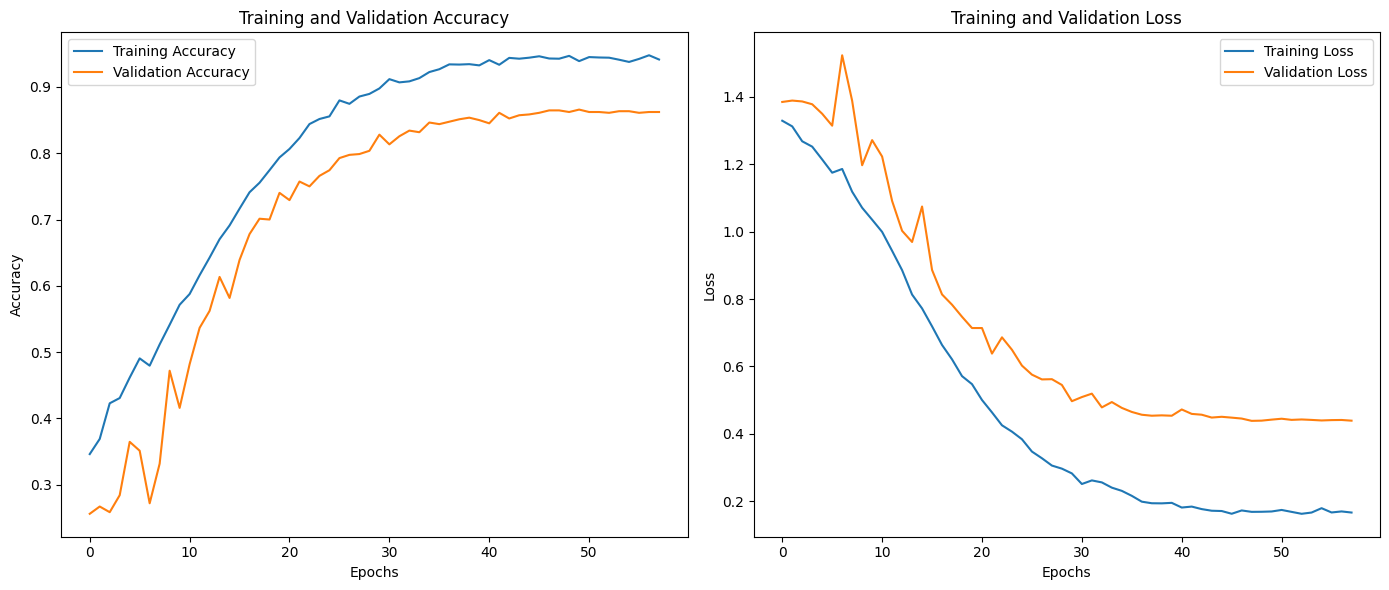

In [ ]:
# Plot the training and validation accuracy and loss side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the training and validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()

# Plot the training and validation loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### Performance classification report

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8573 - loss: 0.5052
Validation Accuracy: 86.46%
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


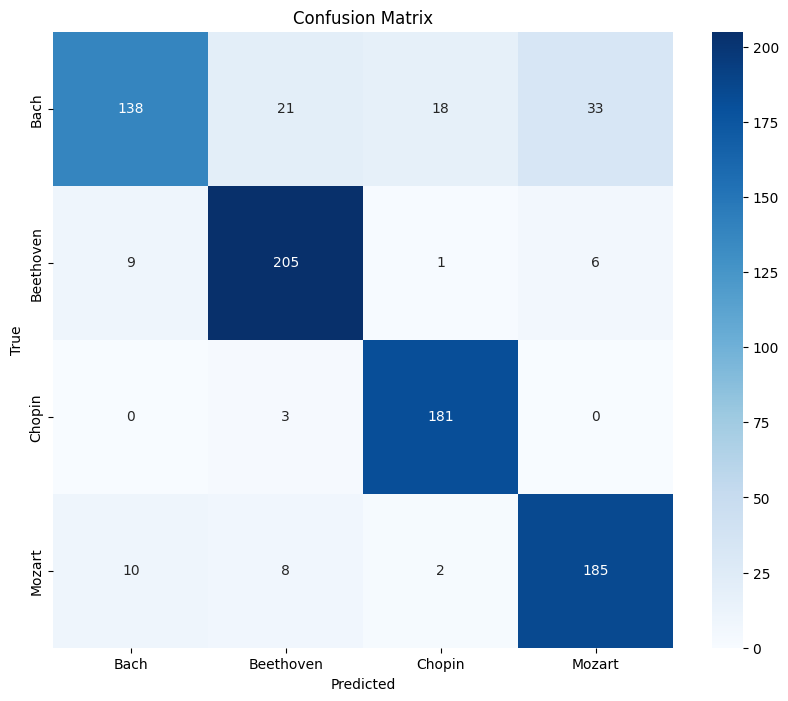

              precision    recall  f1-score   support

        Bach       0.88      0.66      0.75       210
   Beethoven       0.86      0.93      0.90       221
      Chopin       0.90      0.98      0.94       184
      Mozart       0.83      0.90      0.86       205

    accuracy                           0.86       820
   macro avg       0.87      0.87      0.86       820
weighted avg       0.87      0.86      0.86       820



In [ ]:
# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Generate predictions
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

## CNN Model Architecture Summary

The Convolutional Neural Network (CNN) model used in this project is tailored for sequence data analysis, particularly for classifying musical pieces based on extracted MIDI features. The model comprises several layers designed to capture and process temporal patterns effectively:



1. **Input Layer**: Accepts input sequences of length 196 with 32 features each.

2. **First Convolutional Block**:
   - **Conv1D Layer**: Applies 32 filters with a kernel size of 3 to detect local patterns in the sequences.
   - **Batch Normalization**: Normalizes the activations, stabilizing the learning process.
   - **MaxPooling1D Layer**: Reduces dimensionality by taking the maximum value over a pool size of 2.
   - **Dropout Layer**: Prevents overfitting by randomly setting a fraction of the input units to zero.

3. **Second Convolutional Block**:
   - **Conv1D Layer**: Applies 64 filters, enhancing the model's ability to capture more complex patterns.
   - **Batch Normalization**, **MaxPooling1D**, and **Dropout** layers follow similar to the first block.

4. **Third Convolutional Block**:
   - **Conv1D Layer**: Increases the filter count to 128, further capturing intricate features.
   - **Batch Normalization**, **MaxPooling1D**, and **Dropout** layers are included as before.

5. **Flatten Layer**: Converts the 3D output of the last convolutional block to a 1D vector, preparing it for the dense layers.

6. **Fully Connected Layers**:
   - **Dense Layer**: Contains 256 units with ReLU activation, learning high-level representations.
   - **Dropout Layer**: Applied to prevent overfitting.
   - **Output Dense Layer**: Utilizes a softmax activation function to output class probabilities for the four composers.

The model, with a total of `2,224,782` parameters, leverages the power of convolutional layers to capture temporal dependencies and patterns in the MIDI data, enabling effective classification of musical pieces.

In [11]:
# Custom callback for tqdm progress bar
class TqdmCallback(Callback):
    def __init__(self, pbar):
        self.pbar = pbar

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(accuracy=f"{logs['accuracy']:.4f}", loss=f"{logs['loss']:.4f}", val_accuracy=f"{logs['val_accuracy']:.4f}", val_loss=f"{logs['val_loss']:.4f}")

# Define the CNN model
def build_model(optimizer='adam', learning_rate=0.001, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.25, dense_units=256):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)

    model = Sequential([
        Input(shape=(max_len, 1)),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=pool_size),
        Dropout(dropout_rate),
        Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=pool_size),
        Dropout(dropout_rate),
        Conv1D(filters=filters*4, kernel_size=kernel_size, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=pool_size),
        Dropout(dropout_rate),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter grid
param_grid = {
    'optimizer': ['adam'],
    'learning_rate': [0.001, 0.01],
    'filters': [32, 64],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'dropout_rate': [0.10, 0.20],
    'dense_units': [128, 256],
    'batch_size': [32, 64],
    'epochs': [100]
}

# Create all combinations of hyperparameters
param_combinations = list(product(
    param_grid['optimizer'],
    param_grid['learning_rate'],
    param_grid['filters'],
    param_grid['kernel_size'],
    param_grid['pool_size'],
    param_grid['dropout_rate'],
    param_grid['dense_units'],
    param_grid['batch_size'],
    param_grid['epochs']
))

# Encode the target labels
label_encoder = LabelEncoder()
encoded_composers = label_encoder.fit_transform(df['composer'])
categorical_composers = to_categorical(encoded_composers)

# Pad the note sequences to ensure uniform length
max_len = 200  # Define a maximum length for padding
note_sequences = pad_sequences(df['note_sequence'], maxlen=max_len, padding='post')

# Prepare the input features
X = note_sequences
y = encoded_composers  # Use encoded_composers instead of categorical_composers for SMOTE

# Reshape X for SMOTE (SMOTE does not accept 3D arrays)
X_reshaped = X.reshape((X.shape[0], X.shape[1]))

# Apply SMOTE to balance the data
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X_reshaped, y)

# Reshape X_balanced back to 3D array
X_balanced = X_balanced.reshape((X_balanced.shape[0], X.shape[1], 1))

# Convert y_balanced back to categorical
y_balanced = to_categorical(y_balanced)

# Split the balanced data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Store the best parameters and best accuracy
best_params = None
best_accuracy = 0

# Loop over all parameter combinations
for params in param_combinations:
    optimizer, learning_rate, filters, kernel_size, pool_size, dropout_rate, dense_units, batch_size, epochs = params

    # Print the training parameters
    print(f"\nTraining with optimizer={optimizer}, filters={filters}, kernel_size={kernel_size}, pool_size={pool_size}, dropout_rate={dropout_rate}, dense_units={dense_units}, batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")

    # Build and train the model
    model = build_model(
        optimizer=optimizer,
        learning_rate=learning_rate,
        filters=filters,
        kernel_size=kernel_size,
        pool_size=pool_size,
        dropout_rate=dropout_rate,
        dense_units=dense_units
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

    # Train the model with progress bar
    with notebook_tqdm(total=epochs, desc=f"Training Progress", colour='green') as pbar:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr, TqdmCallback(pbar)], verbose=0)

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

    # Check if this is the best model so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        best_history = history
        best_model = model

# Print the best parameters and best accuracy
print(f"\nBest Validation Accuracy: {best_accuracy * 100:.2f}%")
print(f"\nBest Parameters: {best_params}")





Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.001


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=32, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=3, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=2, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.1, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=128, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=32, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Training with optimizer=adam, filters=64, kernel_size=5, pool_size=3, dropout_rate=0.2, dense_units=256, batch_size=64, epochs=100, learning_rate=0.01


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


Best Validation Accuracy: 95.24%

Best Parameters: ('adam', 0.001, 32, 5, 2, 0.1, 256, 32, 100)


### Model Evaluation and Performance Analysis


#### Training and Validation Accuracy and Loss

The plots below represent the training and validation accuracy and loss over the epochs for the best model configuration. The training process shows how well the model is learning and generalizing to new data.

##### Accuracy Plot
- **Training Accuracy**: The accuracy of the model on the training data.
- **Validation Accuracy**: The accuracy of the model on the validation data.

The accuracy graph (left) shows the accuracy of the model on the training and validation datasets over each epoch.

1. **Initial Phase**: In the initial epochs, both training and validation accuracy increase rapidly, indicating that the model is learning from the data.
2. **Mid-Phase**: Around epoch 10, the training accuracy continues to improve, while the validation accuracy starts to fluctuate. This fluctuation indicates that the model is beginning to overfit the training data.
3. **Stabilization**: After epoch 25, both training and validation accuracies stabilize, with the training accuracy slightly higher than the validation accuracy. The model has learned the training data well, but some overfitting might be present as the validation accuracy does not increase as much as the training accuracy.

##### Loss Plot
- **Training Loss**: The loss of the model on the training data.
- **Validation Loss**: The loss of the model on the validation data.

The loss graph (right) shows the loss of the model on the training and validation datasets over each epoch.

1. **Initial Phase**: In the initial epochs, both training and validation loss decrease rapidly, indicating that the model is reducing errors and improving its predictions.
2. **Mid-Phase**: Around epoch 10, the validation loss begins to fluctuate significantly while the training loss continues to decrease. This fluctuation is another sign of overfitting, as the model performs well on training data but not as consistently on validation data.
3. **Stabilization**: After epoch 25, the training loss remains low and stable, while the validation loss stabilizes at a higher value than the training loss. This difference between training and validation loss is another indicator of overfitting.

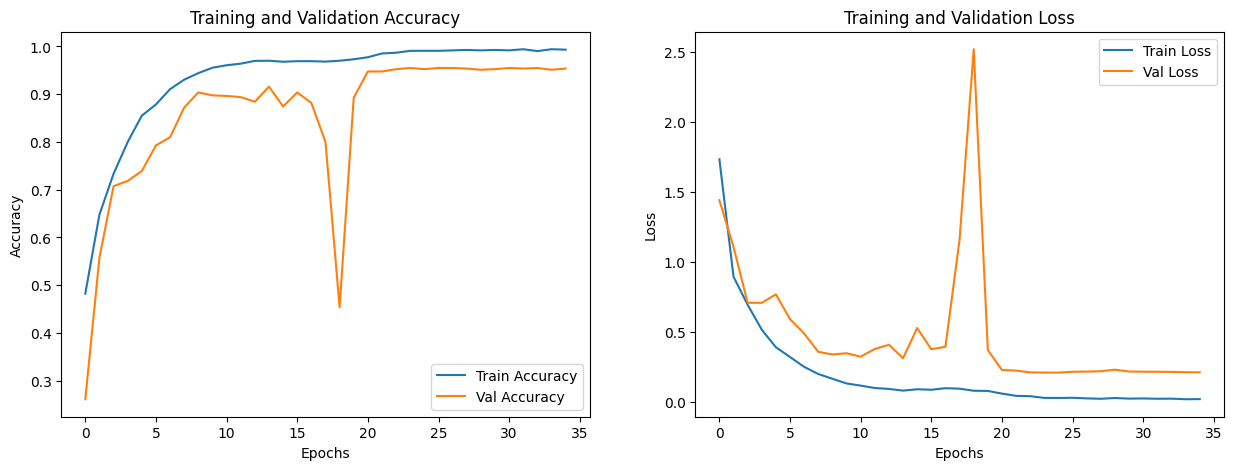

In [12]:
# Plot the training and validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axs[0].plot(best_history.history['accuracy'], label='Train Accuracy')
axs[0].plot(best_history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(best_history.history['loss'], label='Train Loss')
axs[1].plot(best_history.history['val_loss'], label='Val Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()



### Confusion Matrix

The confusion matrix visualizes the performance of the classification model by showing the true positive, false positive, true negative, and false negative predictions for each class.

- **Diagonal Elements**: Correct predictions.
- **Off-Diagonal Elements**: Misclassifications.

### Classification Report

The classification report provides detailed metrics for each class, including precision, recall, and F1-score. These metrics help to understand the performance of the model on each class in the dataset.

#### Precision
- The ratio of correctly predicted positive observations to the total predicted positives.

#### Recall
- The ratio of correctly predicted positive observations to all observations in the actual class.

#### F1-score
- The weighted average of Precision and Recall.


### Conclusion

The model shows a high level of accuracy and performance across all classes, with precision, recall, and F1-scores all around `95%`. The confusion matrix confirms that most predictions are correct, with very few misclassifications. This indicates that the model is robust and performs well on the given task of composer classification based on MIDI file features.

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


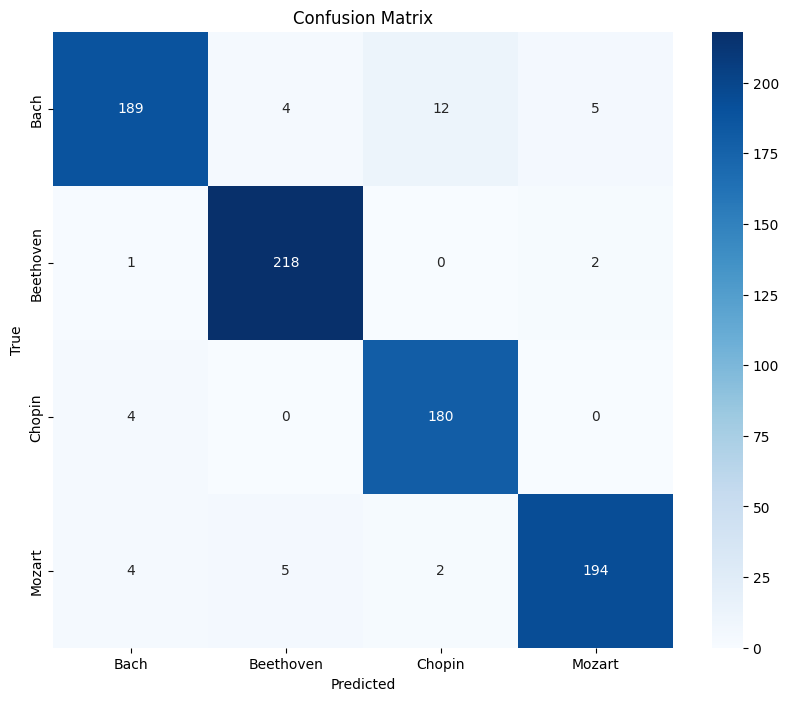

Classification Report:
              precision    recall  f1-score   support

        Bach       0.95      0.90      0.93       210
   Beethoven       0.96      0.99      0.97       221
      Chopin       0.93      0.98      0.95       184
      Mozart       0.97      0.95      0.96       205

    accuracy                           0.95       820
   macro avg       0.95      0.95      0.95       820
weighted avg       0.95      0.95      0.95       820



In [13]:
# Confusion Matrix and Classification Report
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
cr = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(cr)

In [14]:
best_model.summary()

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_252 (Conv1D)                  │ (None, 196, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_252              │ (None, 196, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_252 (MaxPooling1D)     │ (None, 98, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_336 (Dropout)                │ (None, 98, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_253 (Conv1D)                  │ (None, 94, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_253              │ (None, 94, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_253 (MaxPooling1D)     │ (None, 47, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_337 (Dropout)                │ (None, 47, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_254 (Conv1D)                  │ (None, 43, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_254              │ (None, 43, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_254 (MaxPooling1D)     │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_338 (Dropout)                │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_84 (Flatten)                 │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_168 (Dense)                    │ (None, 256)                 │         688,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_339 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_169 (Dense)                    │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,224,782 (8.49 MB)

 Trainable params: 741,444 (2.83 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,482,890 (5.66 MB)

## Transformer Self-Attention Model
The Transformer model, introduced by Vaswani et al. in 2017, has revolutionized the field of natural language processing (NLP) and has been widely adopted in various other domains. One of the key innovations of the Transformer model is the self-attention mechanism, which allows the model to weigh the importance of different parts of the input sequence dynamically.

Total Progress:   0%|          | 0/64 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=128, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=128, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=128, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=128, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=128, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=128, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=128, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=128, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=256, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=256, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=256, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=256, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=256, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=256, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=256, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=4, ff_dim=256, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=128, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=128, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=128, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=128, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=128, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=128, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=128, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=128, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=256, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=256, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=256, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=256, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=256, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=256, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=256, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=32, num_heads=8, ff_dim=256, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=128, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=128, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=128, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=128, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=128, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=128, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=128, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=128, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=256, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=256, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=256, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=256, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=256, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=256, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=256, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=4, ff_dim=256, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=128, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=128, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=128, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=128, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=128, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=128, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=128, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=128, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=256, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=256, rate=0.1, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=256, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=256, rate=0.1, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=256, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=256, rate=0.2, num_blocks=2, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=256, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.001, epochs=100, learning_rate=0.001


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Training with embed_dim=64, num_heads=8, ff_dim=256, rate=0.2, num_blocks=3, batch_size=64, learning_rate=0.01, epochs=100, learning_rate=0.01


Training Progress :   0%|          | 0/100 [00:00<?, ?it/s]


Best Validation Accuracy: 95.37%

Best Parameters: (64, 8, 256, 0.2, 2, 64, 100, 0.001)


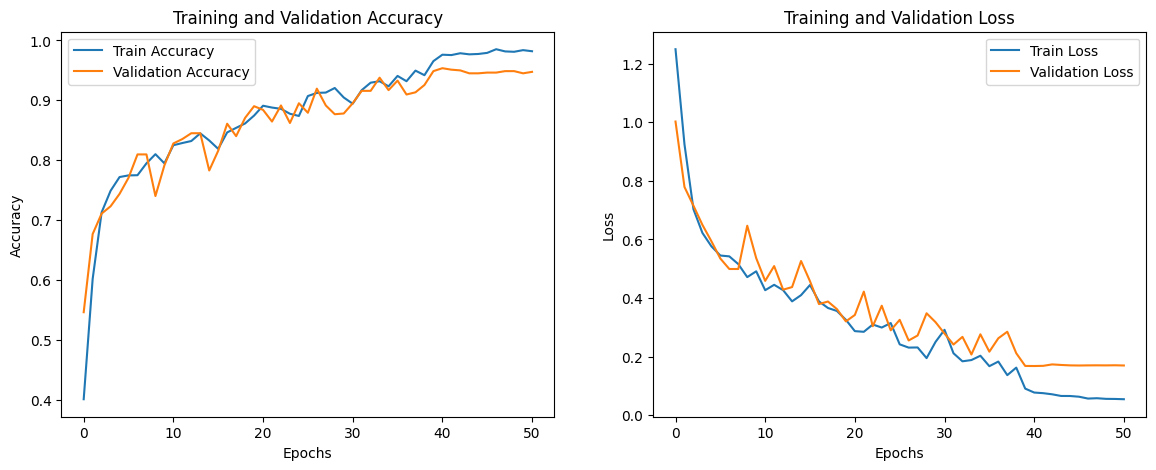

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step


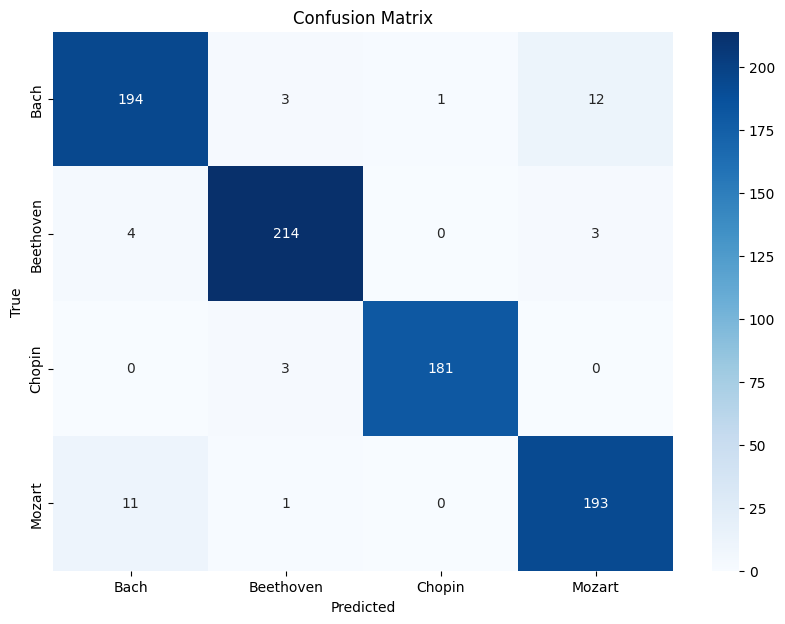

Classification Report
              precision    recall  f1-score   support

        Bach       0.93      0.92      0.93       210
   Beethoven       0.97      0.97      0.97       221
      Chopin       0.99      0.98      0.99       184
      Mozart       0.93      0.94      0.93       205

    accuracy                           0.95       820
   macro avg       0.95      0.95      0.95       820
weighted avg       0.95      0.95      0.95       820



In [27]:
# Load the extracted features dataset
df = pd.read_csv(os.path.join(base_dir,'standardized_midi_features.csv'))

# Ensure the note sequences are properly formatted
df['note_sequence'] = df['note_sequence'].apply(eval)

# Standardize the features
features_to_standardize = [
    'duration', 'tempo', 'average_velocity', 'max_velocity',
    'min_velocity', 'velocity_std', 'pitch_range', 'num_instruments',
    'note_density', 'num_notes', 'average_pitch', 'max_pitch',
    'min_pitch', 'pitch_std', 'articulations'
]

scaler = StandardScaler()
df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

# Encode the target labels
label_encoder = LabelEncoder()
encoded_composers = label_encoder.fit_transform(df['composer'])
categorical_composers = to_categorical(encoded_composers)

# Pad the note sequences to ensure uniform length
max_len = 100  # Define a maximum length for padding
note_sequences = pad_sequences(df['note_sequence'], maxlen=max_len, padding='post')

# Prepare the input features
features = [
    'duration', 'tempo', 'average_velocity', 'max_velocity',
    'min_velocity', 'velocity_std', 'pitch_range', 'num_instruments',
    'note_density', 'num_notes', 'average_pitch', 'max_pitch',
    'min_pitch', 'pitch_std', 'articulations'
]
feature_arrays = []

for feature in features:
    feature_values = np.expand_dims(df[feature].values, axis=1)
    feature_values = np.repeat(feature_values, max_len, axis=1)
    feature_arrays.append(feature_values)

# Combine all feature arrays into one array
X_features = np.stack(feature_arrays, axis=2)

# Stack the features together along with the note sequences
X = np.concatenate([np.expand_dims(note_sequences, axis=-1), X_features], axis=-1)
y = encoded_composers  # Use encoded_composers for SMOTE

# Reshape X for SMOTE (SMOTE does not accept 3D arrays)
X_reshaped = X.reshape((X.shape[0], -1))

# Apply SMOTE to balance the data
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X_reshaped, y)

# Reshape X_balanced back to 3D array
X_balanced = X_balanced.reshape((X_balanced.shape[0], max_len, X.shape[2]))

# Convert y_balanced back to categorical
y_balanced = to_categorical(y_balanced)

# Split the balanced data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def build_model(embed_dim, num_heads, ff_dim, max_len, num_classes, rate=0.1, num_blocks=2):
    inputs = Input(shape=(max_len, X.shape[-1]))
    x = Dense(embed_dim)(inputs)  # Project the input to the embed_dim
    x = PositionalEncoding(max_len, embed_dim)(x)
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, rate)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(rate)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

class TqdmCallback(Callback):
    def __init__(self, outer_pbar, inner_pbar):
        self.outer_pbar = outer_pbar
        self.inner_pbar = inner_pbar

    def on_epoch_end(self, epoch, logs=None):
        self.inner_pbar.update(1)
        self.inner_pbar.set_postfix(accuracy=f"{logs['accuracy']:.4f}", loss=f"{logs['loss']:.4f}", val_accuracy=f"{logs['val_accuracy']:.4f}", val_loss=f"{logs['val_loss']:.4f}")

    def on_train_end(self, logs=None):
        self.outer_pbar.update(1)

# Define the hyperparameter grid
param_grid = {
    'embed_dim': [32, 64],
    'num_heads': [4, 8],
    'ff_dim': [128, 256],
    'rate': [0.1, 0.2],
    'num_blocks': [2, 3],
    'batch_size': [64],
    'epochs': [100],
    'learning_rate': [0.001, 0.01]
}

# Create all combinations of hyperparameters
param_combinations = list(product(
    param_grid['embed_dim'],
    param_grid['num_heads'],
    param_grid['ff_dim'],
    param_grid['rate'],
    param_grid['num_blocks'],
    param_grid['batch_size'],
    param_grid['epochs'],
    param_grid['learning_rate']
))

# Store the best parameters and best accuracy
best_params = None
best_accuracy = 0

# Loop over all parameter combinations with an outer progress bar
with notebook_tqdm(total=len(param_combinations), desc="Total Progress", colour='blue') as outer_pbar:
    for params in param_combinations:

        embed_dim, num_heads, ff_dim, rate, num_blocks, batch_size, epochs, learning_rate = params
        # Print the training parameters
        print(f"\nTraining with embed_dim={embed_dim}, num_heads={num_heads}, ff_dim={ff_dim}, rate={rate}, num_blocks={num_blocks}, batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}, learning_rate={learning_rate}")


        try:
            # Build and train the model
            model = build_model(embed_dim, num_heads, ff_dim, max_len, len(label_encoder.classes_), rate, num_blocks)
            optimizer = AdamW(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            # Callbacks
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

            # Inner progress bar for epochs
            with notebook_tqdm(total=epochs, desc=f"Training Progress ", colour='green') as inner_pbar:
                history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                                    callbacks=[early_stopping, reduce_lr, TqdmCallback(outer_pbar, inner_pbar)], verbose=0)

            # Evaluate the model
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

            # Check if this is the best model so far
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = params
                best_history = history
                best_model = model
        except Exception as e:
            print(f"Error with parameters {params}: {e}")

# Print the best parameters and best accuracy
print(f"\nBest Validation Accuracy: {best_accuracy * 100:.2f}%")
print(f"\nBest Parameters: {best_params}")

# Plot training and validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(best_history.history['accuracy'], label='Train Accuracy')
ax1.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(best_history.history['loss'], label='Train Loss')
ax2.plot(best_history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

# Confusion matrix and classification report
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
cr = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report')
print(cr)
